# Imports

In [1]:
import pandas as pd
import zipfile as zf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from dune_client.client import DuneClient
from dune_client.query import QueryBase
from dotenv import load_dotenv
import os
import asyncio
import aiohttp
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
import os
import pyarrow.dataset as ds
import polars as pl

load_dotenv()
GRAPH = os.getenv("GRAPH")

In [2]:
data = zf.ZipFile('ETHUSDT-aggTrades-2025-10.zip')
df = pd.read_csv(data.open('ETHUSDT-aggTrades-2025-10.csv'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50227412 entries, 0 to 50227411
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   1720750793        int64  
 1   4145.15000000     float64
 2   0.00990000        float64
 3   2902981421        int64  
 4   2902981421.1      int64  
 5   1759276800336276  int64  
 6   False             bool   
 7   True              bool   
dtypes: bool(2), float64(2), int64(4)
memory usage: 2.3 GB


In [4]:
df.to_parquet('ETHUSDT-aggTrades-2025-10.parquet')

# Graph DEX data

In [1]:
import requests
import json

API_KEY = "08359c5477f79891ff91a3ac7c535ef6"   # <-- replace with your key
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"

url = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

query = """
{
  swaps(first: 5, orderBy: timestamp, orderDirection: desc) {
    id
    amount0
    amount1
    sender
    recipient
    timestamp
  }
}
"""

response = requests.post(url, json={"query": query})

# Convert to JSON
data = response.json()

print(json.dumps(data, indent=2))


{
  "data": {
    "swaps": [
      {
        "amount0": "0.000000000000000123",
        "amount1": "-0.000000457590421438",
        "id": "0xd8ac0baab91af5cdda339be3e27f25efa4d0a31e580db0e559dd1401ee591677-391",
        "recipient": "0x62bfd6e1f72611e9e0fccf939ce03d1294e966f3",
        "sender": "0x2626664c2603336e57b271c5c0b26f421741e481",
        "timestamp": "1764459337"
      },
      {
        "amount0": "0.000000000000000123",
        "amount1": "-0.000000457590421438",
        "id": "0x8345c7bc3ea7253ab354fcc88ca42e8ab34fd775fef3ff625da040204608da7b-387",
        "recipient": "0xc190767d14900c5f54bfab64d8028db2678bcf11",
        "sender": "0x2626664c2603336e57b271c5c0b26f421741e481",
        "timestamp": "1764459337"
      },
      {
        "amount0": "-0.006181681540598785",
        "amount1": "14193.490593",
        "id": "0x79fdf10d9d516b9c88b18c61bcd58d0cd7e1ee35d7f8ca949895d10a353bdb26-407",
        "recipient": "0xbf44de8fc9eeeed8615b0b3bc095cb0ddef35e09",
        "sender

## Pull all swaps for a given pool from The Graph

## Search for pools with eth/usdt pair or similar

In [23]:
import requests
import time
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
url = f"https://gateway.thegraph.com/api/{GRAPH}/subgraphs/id/{SUBGRAPH_ID}"

pools = []
skip = 0
batch = 1000

while True:
    query = f"""
    {{
      pools(first: {batch}, skip: {skip}) {{
        id
        feeTier
        token0 {{ symbol id }}
        token1 {{ symbol id }}
      }}
    }}
    """
    r = requests.post(url, json={"query": query}).json()

    if "errors" in r:
        print("ERROR:", r["errors"])
        break

    batch_pools = r["data"]["pools"]
    if not batch_pools:
        break

    pools.extend(batch_pools)
    skip += batch
    time.sleep(0.1)

print("Total pools:", len(pools))


ERROR: [{'message': 'bad indexers: {0x1b7e0068ca1d7929c8c56408d766e1510e54d98d: Unavailable(too far behind), 0x7bb834017672b1135466661d8dd69c5dd0b3bf51: Timeout, 0xe13840a2e92e0cb17a246609b432d0fa2e418774: Timeout, 0xedca8740873152ff30a2696add66d1ab41882beb: BadResponse(unattestable response: Query timed out), 0xf92f430dd8567b0d466358c79594ab58d919a6d4: BadResponse(expected value at line 1 column 1), 0xfeff9093f6b32d0e5cddba743b06a1fedb87c004: Unavailable(too far behind)}'}]
Total pools: 4000


In [25]:
pools

[{'feeTier': '10000',
  'id': '0x0000051c3bd707d5aa50a28eeaf54fb2cbf91196',
  'token0': {'id': '0x24ba86c5d0febedc37a4aad9e67f299b4a7d9f88',
   'symbol': 'CLK1'},
  'token1': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'}},
 {'feeTier': '10000',
  'id': '0x00000f5983451c31d85304b38563ce8893b557a8',
  'token0': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'},
  'token1': {'id': '0x6ccb79fdf6f5cd197c59ea5a7044cf342150ddec',
   'symbol': 'PORTUGUS'}},
 {'feeTier': '10000',
  'id': '0x0000102fc6ce6dee1c693da23b2ee4f76df9462f',
  'token0': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'},
  'token1': {'id': '0x895623ec529c25b6ab49457c52853d0b3c188d94',
   'symbol': 'Celebrate 🎊 for more on Zora 🎉'}},
 {'feeTier': '10000',
  'id': '0x000012903920c8f4e4c8adca4679784b18ecc84f',
  'token0': {'id': '0x4200000000000000000000000000000000000006',
   'symbol': 'WETH'},
  'token1': {'id': '0x4342c5067f43dc750f6a21293c63b5a4

In [24]:
ETH_LIKE = {"ETH", "WETH", "WETH.e", "ETH.e"}
USDT_LIKE = {"USDT", "USDT.e", "USDTe", "axlUSDT", "bridgedUSDT", "USDTb"}

eth_usdt_candidates = []

for p in pools:
    s0 = p["token0"]["symbol"]
    s1 = p["token1"]["symbol"]
    if (s0 in ETH_LIKE and s1 in USDT_LIKE) or (s0 in USDT_LIKE and s1 in ETH_LIKE):
        eth_usdt_candidates.append(p)

print("Found ETH/USDT-like pools:")
for c in eth_usdt_candidates:
    print(c)


Found ETH/USDT-like pools:
{'feeTier': '3000', 'id': '0x007baf34f89b8bb9f1038dbcc00a28bbe19f8317', 'token0': {'id': '0x4200000000000000000000000000000000000006', 'symbol': 'WETH'}, 'token1': {'id': '0x601c6a71747394c97978f18ef77e775b0f29d264', 'symbol': 'USDT'}}


## Symbol names

In [22]:
query = """
{
  swaps(first: 1000, orderBy: timestamp, orderDirection: desc) {
    pool {
      id
      token0 {symbol}
      token1 {symbol}
    }
  }
}
"""

resp = requests.post(url, json={"query": query}).json()

symbols = set()
for s in resp["data"]["swaps"]:
    symbols.add(s["pool"]["token0"]["symbol"])
    symbols.add(s["pool"]["token1"]["symbol"])

print(sorted(symbols))


['$ARTU', '$RDAC', '$stong', '420', 'A0X', 'ADS', 'AERO', 'AFFINE', 'AGE', 'AGENTIC', 'AIXBT', 'ALI', 'ALTT', 'APOLLO-11', 'AUSTIN', 'AVNT', 'AWESOME', 'AWESOME-FLUTTER', 'BANG', 'BARKBARK', 'BASED', 'BCHB', 'BIO', 'BLACKHOLE', 'BNKR', 'BOARDGAME.IO', 'BOB', 'BOOTSTRAPADMIN', 'BORED', 'BOXMOT', 'BRACKY', 'BRUMP', 'BTCB', 'CAMOUFOX', 'CANVAS', 'CARGO-DIST', 'CAW', 'CECIL', 'CGLM', 'CGN', 'CHARLIE', 'CHOKIDAR', 'CLANKER', 'COLIMA', 'COMMANDER.JS', 'COMPROMISE', 'CORE', 'CORNI ', 'CPP2IL', 'CREATE', 'CUPY', 'DAI', 'DAYBYDAYCRM', 'DEAD', 'DEEP-LIVE-CAM', 'DELTA', 'DEUS', 'DEV', 'DOCSGPT', 'DOKPLOY', 'DOLA', 'DYNAMICDATA', 'ENA', 'ENG', 'ESHARE', 'ESX', 'EURC', 'ElonRWA', 'FASTIFY', 'FLOWER', 'FLOWISE', 'FOOMLOTTERY', 'FP-TS', 'FREYA', 'FULLCALENDAR', 'FULLPAGE.JS', 'FUSE', 'GAME', 'GDAL', 'GDK', 'GIT-CLIFF', 'GLANCES', 'GLICOL', 'GLSLVIEWER', 'GMRT', 'GNS', 'GO-RESTFUL', 'GO-ZERO', 'GOACCESS', 'GOCHU', 'GOOEY', 'GYMNASIUM', 'HARMONY', 'HASH', 'HEIMDALL', 'HI.EVENTS', 'HIGHER', 'HOPPSCOTCH'

## Optimized query

In [3]:
import requests
import pandas as pd
import time
import concurrent.futures

# -------------------------
# CONFIGURATION
# -------------------------
API_KEY = GRAPH
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

# Oct 1–3, 2025 (Unix timestamps)
START_TS = 1759276800
END_TS   = 1759449600

# Parallelization settings
WINDOW_SIZE = 3600         # 1 hour windows
MAX_WORKERS = 8            # tune based on your machine
RETRIES = 5                # retry on indexer timeouts

# ETH / USDT SYMBOL VARIANTS
ETH_LIKE = {"ETH", "WETH", "WETH.e", "ETH.e"}
USDT_LIKE = {"USDT", "USDT.e", "USDTe", "axlUSDT", "bridgedUSDT", "USDTb"}


# -------------------------
# QUERY FUNCTION (1-HR WINDOW)
# -------------------------
def fetch_window(start_ts, end_ts, retry=0):
    """Fetch swaps in a small timestamp window with retries."""
    query = f"""
    {{
      swaps(
        first: 1000,
        where: {{
          timestamp_gte: {start_ts},
          timestamp_lt: {end_ts}
        }},
        orderBy: timestamp,
        orderDirection: asc
      ) {{
        id
        timestamp
        amount0
        amount1
        amountUSD
        sender
        recipient
        pool {{
          id
          token0 {{ symbol id }}
          token1 {{ symbol id }}
        }}
      }}
    }}
    """

    try:
        resp = requests.post(URL, json={"query": query}, timeout=20).json()

        if "errors" in resp:
            # Retry on indexer issues
            if retry < RETRIES:
                time.sleep(0.3)
                return fetch_window(start_ts, end_ts, retry + 1)
            else:
                print("FAILED WINDOW:", start_ts, resp["errors"])
                return []

        return resp["data"]["swaps"]

    except requests.exceptions.Timeout:
        if retry < RETRIES:
            return fetch_window(start_ts, end_ts, retry + 1)
        else:
            print("TIMEOUT WINDOW:", start_ts)
            return []


# -------------------------
# PARALLEL EXECUTION
# -------------------------
def fetch_all_swaps():
    """Fetch all swaps across hourly windows in parallel."""
    tasks = []
    ts = START_TS

    while ts < END_TS:
        tasks.append((ts, ts + WINDOW_SIZE))
        ts += WINDOW_SIZE

    results = []
    print(f"Fetching {len(tasks)} hourly windows using {MAX_WORKERS} workers...")

    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [
            executor.submit(fetch_window, start, end)
            for start, end in tasks
        ]
        for f in concurrent.futures.as_completed(futures):
            results.extend(f.result())

    print("Total swaps fetched:", len(results))
    return results


# -------------------------
# EXTRACT ETH/USDT POOLS
# -------------------------
def extract_eth_usdt_pools(swaps):
    pools = set()

    for s in swaps:
        t0 = s["pool"]["token0"]["symbol"]
        t1 = s["pool"]["token1"]["symbol"]
        pid = s["pool"]["id"]

        if (t0 in ETH_LIKE and t1 in USDT_LIKE) or (t1 in ETH_LIKE and t0 in USDT_LIKE):
            pools.add(pid)

    print("ETH/USDT-like pools found:", pools)
    return pools


# -------------------------
# FILTER SWAPS LOCALLY
# -------------------------
def filter_swaps_by_pools(swaps, pools):
    return [s for s in swaps if s["pool"]["id"] in pools]

def normalize_swap(s):
    t0 = s["pool"]["token0"]["symbol"]
    t1 = s["pool"]["token1"]["symbol"]

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # Identify which token is ETH / USDT
    if t0 in ETH_LIKE:
        eth_amount = a0
        usdt_amount = a1
    elif t1 in ETH_LIKE:
        eth_amount = a1
        usdt_amount = a0
    else:
        eth_amount = None
        usdt_amount = None

    # Direction:
    # negative amount means the trader SENT (sold) that token.
    direction = (
        "ETH→USDT" if eth_amount < 0 else
        "USDT→ETH" if usdt_amount < 0 else 
        "unknown"
    )

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "eth_amount": eth_amount,
        "usdt_amount": usdt_amount,
        "direction": direction,
        "pool": s["pool"]["id"]
    }



# -------------------------
# MAIN
# -------------------------
if __name__ == "__main__":
    # 1. Fetch all swaps for Oct 1–3 2025 (fast, parallel)
    all_swaps = fetch_all_swaps()

    # 2. Determine which pools are ETH/USDT-like
    pools = extract_eth_usdt_pools(all_swaps)

    if not pools:
        print("No ETH/USDT pools found in this dataset.")
        exit()

    # 3. Filter locally (avoid querying pools table)
    eth_usdt_swaps = filter_swaps_by_pools(all_swaps, pools)

    # 4. Convert to DataFrame
    df = pd.DataFrame(eth_usdt_swaps)
    normalized = [normalize_swap(s) for s in eth_usdt_swaps]
    df = pd.DataFrame(normalized)
    print(df.head())

    # Save the final result
    df.to_csv("eth_usdt_swaps_2025_oct1_3.csv", index=False)
    print("Saved to eth_usdt_swaps_2025_oct1_3.csv")


Fetching 48 hourly windows using 8 workers...
Total swaps fetched: 48000
ETH/USDT-like pools found: {'0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', '0xd0d182fed9d119e1e41f5199266974f2546eb3f5', '0xce1d8c90a5f0ef28fe0f457e5ad615215899319a'}
                                                  id   timestamp  eth_amount  \
0  0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...  1759276801   -0.007114   
1  0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...  1759276803    0.000330   
2  0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...  1759276803    0.000325   
3  0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...  1759276803    0.000319   
4  0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...  1759276803    0.000305   

   usdt_amount direction                                        pool  
0    29.507649  ETH→USDT  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
1    -1.367409  USDT→ETH  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
2    -1.346510  USDT→ETH  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55

In [5]:
df['eth_price'] = np.abs(df['usdt_amount']/ df['eth_amount'])

In [6]:
df

,id,timestamp,eth_amount,usdt_amount,direction,pool,eth_price
0,0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...,1759276801,-0.007114,29.507649,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4147.802786
1,0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...,1759276803,0.000330,-1.367409,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.835513
2,0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...,1759276803,0.000325,-1.346510,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.856378
3,0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...,1759276803,0.000319,-1.320034,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.798737
4,0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...,1759276803,0.000305,-1.264180,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.818511
...,...,...,...,...,...,...,...
3084,0x3eed809753515783ede1f9b26ab7f4793ba368a7f45f...,1759442461,-0.021686,97.083106,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4476.670494
3085,0x204e51f0d4e1a4dd6f7c475de767a0d7ebb971a198fd...,1759442477,-0.012627,56.535678,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4477.319050
3086,0x9fd3ebefe74303be7f64f72d90173c3477d9ff9a67d0...,1759442479,-0.027441,122.881507,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4478.076568
3087,0xfde657500476d1dd63a5d80882aac92d660f8e1e5a14...,1759442481,-0.010668,47.781082,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4478.797244


In [22]:
import asyncio
import aiohttp
import pandas as pd
import time
import math

# -------------------------
# CONFIG
# -------------------------
API_KEY = GRAPH
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

START_TS = 1759276800
END_TS   = 1759449600

WINDOW_SIZE = 3600  # 1 hour
PAGE_SIZE = 1000
MAX_RETRIES = 5
CONCURRENT_REQUESTS = 40  # tune based on machine/network

ETH_LIKE = {"ETH"}
USDT_LIKE = {"USDT"}

# Canonical token addresses (Arbitrum One)
ETH_ADDRS = {
    "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
    "0x4200000000000000000000000000000000000006",  # Native ETH wrapper (Arbitrum)
}


USDT_ADDRS = {
    '0xfde4c96c8593536e31f229ea8f37b2ada2699bb2'
}


# -------------------------
# GraphQL Query Builder
# -------------------------
def build_query(start_ts, end_ts, skip):
    return {
        "query": f"""
        {{
          swaps(
            first: {PAGE_SIZE},
            skip: {skip},
            where: {{
              timestamp_gte: {start_ts},
              timestamp_lt: {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            pool {{
              id
              token0 {{ symbol id }}
              token1 {{ symbol id }}
            }}
          }}
        }}
        """
    }


# -------------------------
# Async Fetch (Single Request)
# -------------------------
async def fetch_page(session, start_ts, end_ts, skip, retry=0):
    try:
        async with session.post(URL, json=build_query(start_ts, end_ts, skip), timeout=30) as resp:
            data = await resp.json()

            # Handle GraphQL errors
            if "errors" in data:
                if retry < MAX_RETRIES:
                    await asyncio.sleep(0.2)
                    return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
                return []

            return data["data"]["swaps"]

    except Exception:
        if retry < MAX_RETRIES:
            await asyncio.sleep(0.3)
            return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
        return []


# -------------------------
# Fetch ALL Pages for a Window (Paginated)
# -------------------------
async def fetch_window(session, start_ts, end_ts):
    # First page to detect total size
    first_page = await fetch_page(session, start_ts, end_ts, 0)
    if not first_page:
        return []

    pages = [first_page]

    # If first page == PAGE_SIZE, we need pagination
    if len(first_page) == PAGE_SIZE:
        # Worst case, assume 10k swaps per hour → need ~10 pages
        # → aggressively parallelize pagination
        tasks = []
        for k in range(1, 20):  
            skip = k * PAGE_SIZE
            tasks.append(fetch_page(session, start_ts, end_ts, skip))

        all_pages = await asyncio.gather(*tasks)

        for pg in all_pages:
            if pg:
                pages.append(pg)
            if len(pg) < PAGE_SIZE:
                break

    # Flatten
    merged = [row for page in pages for row in page]
    return merged


# -------------------------
# Fetch All Windows in Parallel
# -------------------------
async def fetch_all_swaps():
    tasks = []
    ts = START_TS

    async with aiohttp.ClientSession() as session:
        while ts < END_TS:
            tasks.append(fetch_window(session, ts, ts + WINDOW_SIZE))
            ts += WINDOW_SIZE

        print(f"Launching {len(tasks)} hourly windows in parallel...")

        # Limit concurrency
        sem = asyncio.Semaphore(CONCURRENT_REQUESTS)

        async def sem_task(t):
            async with sem:
                return await t

        results = await asyncio.gather(*[sem_task(t) for t in tasks])

    # Flatten
    all_swaps = [s for window in results for s in window]
    print("Total swaps fetched:", len(all_swaps))
    return all_swaps


# -------------------------
# EXTRACT ETH/USDT POOLS (CORRECTED)
# -------------------------
def extract_eth_usdt_pools(swaps):
    pools = set()

    for s in swaps:
        t0 = s["pool"]["token0"]["id"].lower()
        t1 = s["pool"]["token1"]["id"].lower()
        pid = s["pool"]["id"]

        if (t0 in ETH_ADDRS and t1 in USDT_ADDRS) or \
           (t1 in ETH_ADDRS and t0 in USDT_ADDRS):
            pools.add(pid)

    print("ETH/USDT pools identified:", pools)
    return pools


# -------------------------
# NORMALIZE SWAP DATA
# -------------------------
def normalize_swap(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # Determine which amount belongs to ETH vs USDT
    if t0 in ETH_ADDRS:
        eth = a0
        usdt = a1
    elif t1 in ETH_ADDRS:
        eth = a1
        usdt = a0
    else:
        return None

    direction = "ETH→USDT" if eth < 0 else "USDT→ETH"

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "eth_amount": eth,
        "usdt_amount": usdt,
        "direction": direction,
        "pool": s["pool"]["id"]
    }


# -------------------------
# MAIN
# -------------------------
async def main():
    all_swaps = await fetch_all_swaps()

    pools = extract_eth_usdt_pools(all_swaps)
    if not pools:
        print("No ETH/USDT pools found.")
        return

    # Filter by pools
    eth_usdt_swaps = [s for s in all_swaps if s["pool"]["id"] in pools]

    # Normalize
    normalized = [normalize_swap(s) for s in eth_usdt_swaps]
    normalized = [n for n in normalized if n is not None]

    df = pd.DataFrame(normalized).sort_values("timestamp")

    
    print(df.head())
    print("Total ETH/USDT swaps:", len(df))

    df.to_csv("eth_usdt_swaps_clean.csv", index=False)
    print("Saved → eth_usdt_swaps_clean.csv")

# -------------------------
# RUN
# -------------------------
import nest_asyncio
nest_asyncio.apply()

await main()



Launching 48 hourly windows in parallel...
Total swaps fetched: 960000
ETH/USDT pools identified: {'0x05e5995e09a4494fdc1ede4c1eb02221898bdd48', '0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', '0xd0d182fed9d119e1e41f5199266974f2546eb3f5', '0xce1d8c90a5f0ef28fe0f457e5ad615215899319a'}
                                                  id   timestamp  eth_amount  \
0  0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...  1759276801   -0.007114   
1  0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...  1759276803    0.000330   
2  0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...  1759276803    0.000325   
3  0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...  1759276803    0.000319   
4  0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...  1759276803    0.000305   

   usdt_amount direction                                        pool  
0    29.507649  ETH→USDT  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
1    -1.367409  USDT→ETH  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f  
2    -1.346510  USDT→ET

In [21]:
# -----------------------------------------
# Detect ETH-like and USDT-like tokens by symbol
# -----------------------------------------

ETH_SYM = {"ETH", "WETH", "WETH.e", "ETH.e"}
USDT_SYM = {"USDT", "USDT.e", "USDTb", "USDTe", "TETHER"}

eth_like_tokens = {}   # symbol -> set(addresses)
usdt_like_tokens = {}  # symbol -> set(addresses)

for s in all_swaps:
    t0 = s["pool"]["token0"]
    t1 = s["pool"]["token1"]

    sym0 = t0["symbol"].upper()
    sym1 = t1["symbol"].upper()

    # Collect ETH-like
    if sym0 in ETH_SYM:
        eth_like_tokens.setdefault(sym0, set()).add(t0["id"].lower())
    if sym1 in ETH_SYM:
        eth_like_tokens.setdefault(sym1, set()).add(t1["id"].lower())

    # Collect USDT-like
    if sym0 in USDT_SYM:
        usdt_like_tokens.setdefault(sym0, set()).add(t0["id"].lower())
    if sym1 in USDT_SYM:
        usdt_like_tokens.setdefault(sym1, set()).add(t1["id"].lower())


print("\n🔵 ETH-like token IDs discovered:")
for sym, addrs in eth_like_tokens.items():
    print(f"  {sym}: {list(addrs)}")

print("\n🟢 USDT-like token IDs discovered:")
for sym, addrs in usdt_like_tokens.items():
    print(f"  {sym}: {list(addrs)}")


# -----------------------------------------
# Now find all pools that contain BOTH
# ETH-like and USDT-like tokens
# -----------------------------------------
eth_addrs = {a for addrs in eth_like_tokens.values() for a in addrs}
usdt_addrs = {a for addrs in usdt_like_tokens.values() for a in addrs}

eth_usdt_pools = set()

for s in all_swaps:
    p = s["pool"]
    t0 = p["token0"]["id"].lower()
    t1 = p["token1"]["id"].lower()

    if (t0 in eth_addrs and t1 in usdt_addrs) or \
       (t1 in eth_addrs and t0 in usdt_addrs):
        eth_usdt_pools.add(p["id"])

print("\n🟣 ETH/USDT-like pools detected:")
for pid in eth_usdt_pools:
    print(" ", pid)


# -----------------------------------------
# Sample swaps from ETH/USDT-like pools
# -----------------------------------------
sample = [s for s in all_swaps if s["pool"]["id"] in eth_usdt_pools][:10]

print("\n🟡 Sample ETH/USDT-like swaps:")
for s in sample:
    print({
        "id": s["id"],
        "timestamp": s["timestamp"],
        "pool": s["pool"]["id"],
        "token0": s["pool"]["token0"]["symbol"],
        "token1": s["pool"]["token1"]["symbol"],
        "amount0": s["amount0"],
        "amount1": s["amount1"],
    })



🔵 ETH-like token IDs discovered:
  WETH: ['0x4200000000000000000000000000000000000006']

🟢 USDT-like token IDs discovered:
  USDT: ['0xfde4c96c8593536e31f229ea8f37b2ada2699bb2']

🟣 ETH/USDT-like pools detected:
  0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
  0xd0d182fed9d119e1e41f5199266974f2546eb3f5
  0xce1d8c90a5f0ef28fe0f457e5ad615215899319a

🟡 Sample ETH/USDT-like swaps:
{'id': '0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da10fec807d30b2a710f37a-551', 'timestamp': '1759276801', 'pool': '0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', 'token0': 'WETH', 'token1': 'USDT', 'amount0': '-0.007114043391720232', 'amount1': '29.507649'}
{'id': '0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461248be5d050320820c893-444', 'timestamp': '1759276803', 'pool': '0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f', 'token0': 'WETH', 'token1': 'USDT', 'amount0': '0.000329986312341618', 'amount1': '-1.367409'}
{'id': '0x812360882ce057152a07f9d3ff0a2d9834fce72ac5119293aaacb203436f1f06-436', 'timestamp': '1759276803',

In [19]:
print("Sample swap response:")
print(all_swaps[0])

Sample swap response:
{'amount0': '-0.002006414735868805', 'amount1': '3213.267011867388439921', 'amountUSD': '8.31725415653267907306834597787148', 'id': '0x126a29316acde7875160cc2f329779a8eee675e082ebbdf294e66fd78c630627-509', 'pool': {'id': '0xfb559d225343a61884d46eee91c1a805759f758b', 'token0': {'id': '0x4200000000000000000000000000000000000006', 'symbol': 'WETH'}, 'token1': {'id': '0x90ec58ef4cc9f37b96de1e203b65bd4e6e79580e', 'symbol': 'AMETA'}}, 'recipient': '0x25816d8fa5f061e4d9d2cc1f2300ea4c161191d1', 'sender': '0x2626664c2603336e57b271c5c0b26f421741e481', 'timestamp': '1759276801'}


In [2]:
df = pd.read_csv('eth_usdt_swaps_clean.csv')
df['eth_price'] = np.abs(df['usdt_amount']/df['eth_amount'])
df

,id,timestamp,eth_amount,usdt_amount,direction,pool,eth_price
0,0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...,1759276801,-0.007114,29.507649,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4147.802786
1,0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...,1759276803,0.000330,-1.367409,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.835513
2,0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...,1759276803,0.000325,-1.346510,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.856378
3,0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...,1759276803,0.000319,-1.320034,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.798737
4,0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...,1759276803,0.000305,-1.264180,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4143.818511
...,...,...,...,...,...,...,...
62668,0x9380f9ddb6c4fb8d869fcd6e9a5edcde76b1fb7da0ea...,1759447291,-0.000039,0.176587,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4481.427508
62669,0x8c646d70f0ccccafb76ca4e6679e39aec69ff3183c9f...,1759447307,-0.003879,17.382916,ETH→USDT,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4481.472474
62670,0x84f45bbfcea896d7688ea7f89353f973702c8726fc0b...,1759447339,0.000224,-1.002500,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4477.050474
62671,0x80981cfadb8cf8cf810a1d65451c3a3ab6043169bf8f...,1759447355,0.012070,-54.034506,USDT→ETH,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f,4476.853787


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')

Text(0, 0.5, 'ETH price in USDT')

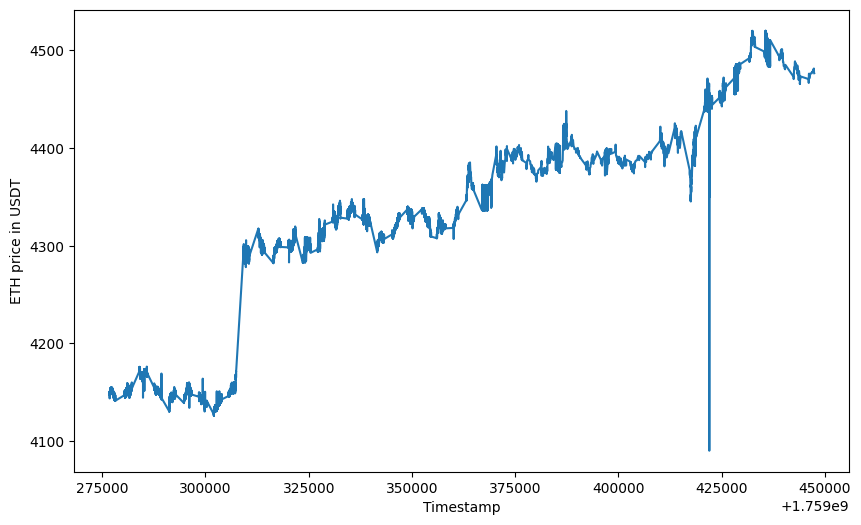

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(df['timestamp'], df['eth_price'])
plt.xlabel('Timestamp')
plt.ylabel('ETH price in USDT')

In [ ]:
import asyncio
import aiohttp
import pandas as pd
import time
import math

# -------------------------
# CONFIG
# -------------------------
API_KEY = GRAPH
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

START_TS = 1759276800
END_TS   = 1759449600

WINDOW_SIZE = 3600  # 1 hour
PAGE_SIZE = 1000
MAX_RETRIES = 5
CONCURRENT_REQUESTS = 40  # tune based on machine/network

ETH_LIKE = {"ETH"}
USDT_LIKE = {"USDT"}

# Canonical token addresses (Arbitrum One)
ETH_ADDRS = {
    "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",  # WETH
    "0x4200000000000000000000000000000000000006",  # Native ETH wrapper (Arbitrum)
}


USDT_ADDRS = {
    '0xfde4c96c8593536e31f229ea8f37b2ada2699bb2'
}


# -------------------------
# GraphQL Query Builder
# -------------------------
def build_query(start_ts, end_ts, skip):
    return {
        "query": f"""
        {{
          swaps(
            first: {PAGE_SIZE},
            skip: {skip},
            where: {{
              timestamp_gte: {start_ts},
              timestamp_lt: {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            pool {{
              id
              token0 {{ symbol id }}
              token1 {{ symbol id }}
            }}
          }}
        }}
        """
    }


# -------------------------
# Async Fetch (Single Request)
# -------------------------
async def fetch_page(session, start_ts, end_ts, skip, retry=0):
    try:
        async with session.post(URL, json=build_query(start_ts, end_ts, skip), timeout=30) as resp:
            data = await resp.json()

            # Handle GraphQL errors
            if "errors" in data:
                if retry < MAX_RETRIES:
                    await asyncio.sleep(0.2)
                    return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
                return []

            return data["data"]["swaps"]

    except Exception:
        if retry < MAX_RETRIES:
            await asyncio.sleep(0.3)
            return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
        return []


# -------------------------
# Fetch ALL Pages for a Window (Paginated)
# -------------------------
async def fetch_window(session, start_ts, end_ts):
    # First page to detect total size
    first_page = await fetch_page(session, start_ts, end_ts, 0)
    if not first_page:
        return []

    pages = [first_page]

    # If first page == PAGE_SIZE, we need pagination
    if len(first_page) == PAGE_SIZE:
        # Worst case, assume 10k swaps per hour → need ~10 pages
        # → aggressively parallelize pagination
        tasks = []
        for k in range(1, 20):  
            skip = k * PAGE_SIZE
            tasks.append(fetch_page(session, start_ts, end_ts, skip))

        all_pages = await asyncio.gather(*tasks)

        for pg in all_pages:
            if pg:
                pages.append(pg)
            if len(pg) < PAGE_SIZE:
                break

    # Flatten
    merged = [row for page in pages for row in page]
    return merged


# -------------------------
# Fetch All Windows in Parallel
# -------------------------
async def fetch_all_swaps():
    tasks = []
    ts = START_TS

    async with aiohttp.ClientSession() as session:
        while ts < END_TS:
            tasks.append(fetch_window(session, ts, ts + WINDOW_SIZE))
            ts += WINDOW_SIZE

        print(f"Launching {len(tasks)} hourly windows in parallel...")

        # Limit concurrency
        sem = asyncio.Semaphore(CONCURRENT_REQUESTS)

        async def sem_task(t):
            async with sem:
                return await t

        results = await asyncio.gather(*[sem_task(t) for t in tasks])

    # Flatten
    all_swaps = [s for window in results for s in window]
    print("Total swaps fetched:", len(all_swaps))
    return all_swaps


# -------------------------
# EXTRACT ETH/USDT POOLS (CORRECTED)
# -------------------------
def extract_eth_usdt_pools(swaps):
    pools = set()

    for s in swaps:
        t0 = s["pool"]["token0"]["id"].lower()
        t1 = s["pool"]["token1"]["id"].lower()
        pid = s["pool"]["id"]

        if (t0 in ETH_ADDRS and t1 in USDT_ADDRS) or \
           (t1 in ETH_ADDRS and t0 in USDT_ADDRS):
            pools.add(pid)

    print("ETH/USDT pools identified:", pools)
    return pools


# -------------------------
# NORMALIZE SWAP DATA
# -------------------------
def normalize_swap(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # Determine which amount belongs to ETH vs USDT
    if t0 in ETH_ADDRS:
        eth = a0
        usdt = a1
    elif t1 in ETH_ADDRS:
        eth = a1
        usdt = a0
    else:
        return None

    direction = "ETH→USDT" if eth < 0 else "USDT→ETH"

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "eth_amount": eth,
        "usdt_amount": usdt,
        "direction": direction,
        "pool": s["pool"]["id"]
    }


# -------------------------
# MAIN
# -------------------------
async def main():
    all_swaps = await fetch_all_swaps()

    pools = extract_eth_usdt_pools(all_swaps)
    if not pools:
        print("No ETH/USDT pools found.")
        return

    # Filter by pools
    eth_usdt_swaps = [s for s in all_swaps if s["pool"]["id"] in pools]

    # Normalize
    normalized = [normalize_swap(s) for s in eth_usdt_swaps]
    normalized = [n for n in normalized if n is not None]

    df = pd.DataFrame(normalized).sort_values("timestamp")

    
    print(df.head())
    print("Total ETH/USDT swaps:", len(df))

    df.to_csv("eth_usdt_swaps_clean.csv", index=False)
    print("Saved → eth_usdt_swaps_clean.csv")

# -------------------------
# RUN
# -------------------------
import nest_asyncio
nest_asyncio.apply()

await main()



In [3]:
pip install pyarrow

   ---------------------------------------- 0.0/28.0 MB ? eta -:--:--
   ------------ --------------------------- 8.7/28.0 MB 51.7 MB/s eta 0:00:01
   ------------------ --------------------- 12.8/28.0 MB 36.1 MB/s eta 0:00:01
   ----------------------- ---------------- 16.8/28.0 MB 29.1 MB/s eta 0:00:01
   ----------------------------- ---------- 20.4/28.0 MB 25.6 MB/s eta 0:00:01
   ---------------------------------- ----- 24.4/28.0 MB 24.5 MB/s eta 0:00:01
   ---------------------------------------  27.8/28.0 MB 23.7 MB/s eta 0:00:01
   ---------------------------------------- 28.0/28.0 MB 22.8 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import asyncio
import aiohttp
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime

# -------------------------
# CONFIG
# -------------------------
API_KEY = GRAPH
SUBGRAPH_ID = "HMuAwufqZ1YCRmzL2SfHTVkzZovC9VL2UAKhjvRqKiR1"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

# FULL OCTOBER 2025
START_TS = 1759276800   # Oct 1 00:00 UTC
END_TS   = 1761955200   # Nov 1 00:00 UTC

WINDOW_SIZE = 3600        # hourly windows
PAGE_SIZE = 1000
MAX_RETRIES = 5
CONCURRENT_REQUESTS = 45   # tune as needed

# Where to save results
OUT_ALL_PARQUET = "all_swaps_oct.parquet"
OUT_ETHUSDT_PARQUET = "eth_usdt_oct.parquet"

# Token classification
ETH_ADDRS = {
    "0x4200000000000000000000000000000000000006",
    "0x82af49447d8a07e3bd95bd0d56f35241523fbab1",
}

USDT_ADDRS = {
    "0xfde4c96c8593536e31f229ea8f37b2ada2699bb2"
}

# -------------------------
# QUERY
# -------------------------
def build_query(start_ts, end_ts, skip):
    return {
        "query": f"""
        {{
          swaps(
            first: {PAGE_SIZE},
            skip: {skip},
            where: {{
              timestamp_gte: {start_ts},
              timestamp_lt:  {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            pool {{
              id
              token0 {{ id symbol }}
              token1 {{ id symbol }}
            }}
          }}
        }}
        """
    }

# -------------------------
# FETCH PAGE
# -------------------------
async def fetch_page(session, start_ts, end_ts, skip, retry=0):
    try:
        async with session.post(URL, json=build_query(start_ts, end_ts, skip), timeout=30) as resp:
            data = await resp.json()

            if "errors" in data:
                if retry < MAX_RETRIES:
                    await asyncio.sleep(0.25)
                    return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
                print("Error in window:", start_ts, data["errors"])
                return []

            return data["data"]["swaps"]

    except Exception:
        if retry < MAX_RETRIES:
            await asyncio.sleep(0.3)
            return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
        return []

# -------------------------
# FETCH WINDOW
# -------------------------
async def fetch_window(session, start_ts, end_ts):
    first = await fetch_page(session, start_ts, end_ts, 0)
    if not first:
        return []

    pages = [first]

    if len(first) == PAGE_SIZE:
        tasks = []
        for k in range(1, 20):
            tasks.append(fetch_page(session, start_ts, end_ts, PAGE_SIZE*k))

        results = await asyncio.gather(*tasks)

        for pg in results:
            if pg:
                pages.append(pg)
            if len(pg) < PAGE_SIZE:
                break

    flat = [x for p in pages for x in p]
    return flat

# -------------------------
# ETH/USDT FILTERING
# -------------------------
def is_eth_usdt_swap(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()
    return (t0 in ETH_ADDRS and t1 in USDT_ADDRS) or (t1 in ETH_ADDRS and t0 in USDT_ADDRS)

# -------------------------
# NORMALIZATION
# -------------------------
def normalize_trade(s):
    t0 = s["pool"]["token0"]
    t1 = s["pool"]["token1"]

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # Define token A/B consistently
    symbolA = t0["symbol"]
    symbolB = t1["symbol"]

    # Price = how many B for 1 A (if possible)
    priceA = None
    if a0 != 0:
        priceA = -a1 / a0   # B per A

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "symbolA": symbolA,
        "symbolB": symbolB,
        "qtyA": a0,
        "qtyB": a1,
        "priceB_per_A": priceA,
        "pool": s["pool"]["id"]
    }

# -------------------------
# PARQUET APPEND HELPERS
# -------------------------
def append_parquet(path, rows):
    if not rows:
        return

    df = pd.DataFrame(rows)

    # Create date partition key
    df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))

    table = pa.Table.from_pandas(df)

    pq.write_to_dataset(
        table,
        root_path=path,
        partition_cols=["date"],   # <-- partition by day, not second
    )

# -------------------------
# MAIN MONTH FETCH
# -------------------------
async def main():
    print("🚀 Starting full October fetch...")

    tasks = []
    ts = START_TS
    day_index = 0

    async with aiohttp.ClientSession() as session:
        # Make list of hourly tasks
        while ts < END_TS:
            tasks.append((ts, ts + WINDOW_SIZE))
            ts += WINDOW_SIZE

        print(f"➡️  {len(tasks)} hourly windows to process")

        # Concurrency control
        sem = asyncio.Semaphore(CONCURRENT_REQUESTS)

        async def wrapped(t1, t2):
            async with sem:
                return await fetch_window(session, t1, t2)

        # Fetch results in streaming fashion
        total_swaps = 0
        total_eth_usdt = 0

        for i in range(0, len(tasks), CONCURRENT_REQUESTS):
            batch = tasks[i:i+CONCURRENT_REQUESTS]

            windows = await asyncio.gather(*[
                wrapped(start, end) for (start, end) in batch
            ])

            # Flatten results
            flat = [s for w in windows for s in w]
            total_swaps += len(flat)

            # Build normalized ALL-trade rows
            all_rows = [normalize_trade(s) for s in flat]

            # Filter ETH/USDT
            eth_usdt_rows = [r for (r, s) in zip(all_rows, flat) if is_eth_usdt_swap(s)]
            total_eth_usdt += len(eth_usdt_rows)

            # Append parquet files
            append_parquet(OUT_ALL_PARQUET, all_rows)
            append_parquet(OUT_ETHUSDT_PARQUET, eth_usdt_rows)

            # Verbose status
            pct = round((i+CONCURRENT_REQUESTS)/len(tasks)*100, 2)
            print(
                f"[{pct}%] processed up to window index {i+CONCURRENT_REQUESTS} "
                f"| total swaps={total_swaps:,} | eth/usdt={total_eth_usdt:,}"
            )

    print("\n✅ DONE!")
    print(f"Total swaps collected: {total_swaps:,}")
    print(f"Total ETH/USDT swaps: {total_eth_usdt:,}")
    print(f"Saved all swaps → {OUT_ALL_PARQUET}")
    print(f"Saved eth-usdt swaps → {OUT_ETHUSDT_PARQUET}")


# -------------------------
# NOTEBOOK SAFE
# -------------------------
import nest_asyncio
nest_asyncio.apply()

await main()


🚀 Starting full October fetch...
➡️  744 hourly windows to process


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[6.05%] processed up to window index 45 | total swaps=900,000 | eth/usdt=62,491


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[12.1%] processed up to window index 90 | total swaps=1,800,000 | eth/usdt=66,996


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[18.15%] processed up to window index 135 | total swaps=2,700,000 | eth/usdt=72,093


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[24.19%] processed up to window index 180 | total swaps=3,600,000 | eth/usdt=78,359


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[30.24%] processed up to window index 225 | total swaps=4,500,000 | eth/usdt=83,910


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[36.29%] processed up to window index 270 | total swaps=5,400,000 | eth/usdt=91,811


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[42.34%] processed up to window index 315 | total swaps=6,300,000 | eth/usdt=101,529


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[48.39%] processed up to window index 360 | total swaps=7,200,000 | eth/usdt=121,082


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[54.44%] processed up to window index 405 | total swaps=8,100,000 | eth/usdt=126,858


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[60.48%] processed up to window index 450 | total swaps=9,000,000 | eth/usdt=130,865


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[66.53%] processed up to window index 495 | total swaps=9,900,000 | eth/usdt=135,084


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[72.58%] processed up to window index 540 | total swaps=10,800,000 | eth/usdt=145,478


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[78.63%] processed up to window index 585 | total swaps=11,700,000 | eth/usdt=150,010


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[84.68%] processed up to window index 630 | total swaps=12,600,000 | eth/usdt=152,996


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[90.73%] processed up to window index 675 | total swaps=13,500,000 | eth/usdt=157,665


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[96.77%] processed up to window index 720 | total swaps=14,400,000 | eth/usdt=163,345


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\39593241.py:167: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[102.82%] processed up to window index 765 | total swaps=14,880,000 | eth/usdt=166,737

✅ DONE!
Total swaps collected: 14,880,000
Total ETH/USDT swaps: 166,737
Saved all swaps → all_swaps_oct.parquet
Saved eth-usdt swaps → eth_usdt_oct.parquet


# Cex/DEX data aggregation

In [9]:
import pyarrow.dataset as ds

dataset = ds.dataset("eth_usdt_oct.parquet", format="parquet")
table = dataset.to_table()
df = table.to_pandas()
df

,id,timestamp,symbolA,symbolB,qtyA,qtyB,priceB_per_A,pool
0,0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...,1759276801,WETH,USDT,-0.007114,29.507649,4147.802786,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
1,0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...,1759276803,WETH,USDT,0.000330,-1.367409,4143.835513,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
2,0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...,1759276803,WETH,USDT,0.000325,-1.346510,4143.856378,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
3,0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...,1759276803,WETH,USDT,0.000319,-1.320034,4143.798737,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
4,0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...,1759276803,WETH,USDT,0.000305,-1.264180,4143.818511,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
...,...,...,...,...,...,...,...,...
166732,0xe0bfad42e8b8d307551632b1e2c0898fb61d7dc9d33c...,1761954257,WETH,USDT,-0.001542,5.949510,3858.177483,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
166733,0x4863510d34694a2144cb22c5654a1ff201819fc78435...,1761954269,WETH,USDT,-0.001542,5.949510,3858.239828,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
166734,0x68d8757ba01b9f450590c22519b4efb44d868414e9e7...,1761954307,WETH,USDT,-0.008615,33.242141,3858.445123,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
166735,0xb66cd126b575cf5a6b4125982d0959b97ec5b478bc18...,1761954337,WETH,USDT,-0.000060,0.232389,3858.633795,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f


In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')

In [ ]:
dataset = ds.dataset("ETHUSDT-aggTrades-2025-10.parquet", format="parquet")
eth_usdt = dataset.to_table().to_pandas()
eth_usdt.columns = ['agg_trade_id', 'price', 'quantity', 'first_trade_id', 'last_trade_id', 'timestamp', 'is_buyer_maker', 'is_best_match']
eth_usdt['timestamp'] = pd.to_datetime(eth_usdt['timestamp'], unit = 'us')

,agg_trade_id,price,quantity,first_trade_id,last_trade_id,timestamp,is_buyer_maker,is_best_match
0,1720750794,4145.15,2.0509,2902981422,2902981434,1759276800962468,False,True
1,1720750795,4145.16,0.2192,2902981435,2902981440,1759276800962468,False,True
2,1720750796,4145.17,0.0133,2902981441,2902981443,1759276800962468,False,True
3,1720750797,4145.18,0.0033,2902981444,2902981445,1759276800962468,False,True
4,1720750798,4145.19,0.0013,2902981446,2902981446,1759276800962468,False,True
...,...,...,...,...,...,...,...,...
50227407,1770978201,3847.99,0.0182,3085461440,3085461440,1761955197626545,True,True
50227408,1770978202,3847.99,0.0025,3085461441,3085461441,1761955198841962,True,True
50227409,1770978203,3847.99,14.1407,3085461442,3085461445,1761955198913534,True,True
50227410,1770978204,3847.99,0.0044,3085461446,3085461446,1761955199595158,True,True


## Timestamp deltas

In [ ]:
import numpy as np
import pandas as pd

dataset = ds.dataset("ETHUSDT-aggTrades-2025-10.parquet", format="parquet")
eth_usdt = dataset.to_table().to_pandas()
eth_usdt.columns = ['agg_trade_id', 'price', 'quantity', 'first_trade_id', 'last_trade_id', 'timestamp', 'is_buyer_maker', 'is_best_match']
eth_usdt['timestamp'] = pd.to_datetime(eth_usdt['timestamp'], unit = 'us')

df_dex = df.copy()
df_cex = eth_usdt.copy()
# df_dex: DEX swaps DataFrame (timestamp in seconds)
# df_cex: Binance aggTrades (timestamp in milliseconds or microseconds)

# Normalize timestamps to milliseconds:
df_dex["ts_ms"] = df_dex["timestamp"].view('int64') // 1_000_000
df_cex["ts_ms"] = df_cex["timestamp"].view('int64') // 1_000_000   # convert microseconds → ms

cex_ts = df_cex["ts_ms"].values

# Find nearest CEX tick for every DEX event
nearest_idx = np.searchsorted(cex_ts, df_dex["ts_ms"])
nearest_idx = np.clip(nearest_idx, 1, len(cex_ts)-1)

deltas = np.abs(cex_ts[nearest_idx] - df_dex["ts_ms"].values)

print("Median delta (ms):", np.median(deltas))
print("90th percentile delta (ms):", np.percentile(deltas, 90))
print("99th percentile delta (ms):", np.percentile(deltas, 99))

C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2549678826.py:9: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_dex["ts_ms"] = df_dex["timestamp"].view('int64') // 1_000_000
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2549678826.py:10: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_cex["ts_ms"] = df_cex["timestamp"].view('int64') // 1_000_000   # convert microseconds → ms


Median delta (ms): 213.0
90th percentile delta (ms): 1022.0
99th percentile delta (ms): 2635.0


In [20]:
df_dex.columns

Index(['id', 'timestamp', 'symbolA', 'symbolB', 'qtyA', 'qtyB', 'priceB_per_A',
       'pool', 'ts_ms'],
      dtype='object')

In [21]:
df_cex.columns

Index(['agg_trade_id', 'price', 'quantity', 'first_trade_id', 'last_trade_id',
       'timestamp', 'is_buyer_maker', 'is_best_match', 'ts_ms'],
      dtype='object')

In [27]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# df_dex columns:
# ['id', 'timestamp', 'symbolA', 'symbolB', 'qtyA', 'qtyB',
#  'priceB_per_A', 'pool', 'ts_ms']
#
# df_cex columns:
# ['agg_trade_id', 'price', 'quantity', 'first_trade_id',
#  'last_trade_id', 'timestamp', 'is_buyer_maker',
#  'is_best_match', 'ts_ms']
# ---------------------------------------------------------


# ---------------------------------------------------------
# 1. Ensure timestamps are in milliseconds
# ---------------------------------------------------------

# DEX: timestamp is seconds → ts_ms already present
df_dex["ts_ms"] = df_dex["ts_ms"].astype("int64")

# CEX: timestamp is ms → ts_ms already present
df_cex["ts_ms"] = df_cex["ts_ms"].astype("int64")


# ---------------------------------------------------------
# 2. Compute DEX price
# ---------------------------------------------------------
# priceB_per_A is already "USDT per ETH"-style, so use that.

df_dex["price"] = df_dex["priceB_per_A"].astype(float)

# Use qtyA as the volume weight (ETH size)
df_dex["volume"] = df_dex["qtyA"].abs()


# ---------------------------------------------------------
# 3. Prepare CEX fields for VWAP
# ---------------------------------------------------------
df_cex["price"] = df_cex["price"].astype(float)
df_cex["volume"] = df_cex["quantity"].abs()


# ---------------------------------------------------------
# 4. Define 3-second bins
# ---------------------------------------------------------
BIN_MS = 3000  # 3 seconds

df_dex["bin"] = (df_dex["ts_ms"] // BIN_MS) * BIN_MS
df_cex["bin"] = (df_cex["ts_ms"] // BIN_MS) * BIN_MS


# ---------------------------------------------------------
# 5. Compute VWAP per 3-second bin
# ---------------------------------------------------------

# --- DEX VWAP ---
dex_vwap = (
    df_dex.groupby("bin")
          .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())
          .rename("dex_price")
          .to_frame()
)

# --- CEX VWAP ---
cex_vwap = (
    df_cex.groupby("bin")
          .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())
          .rename("cex_price")
          .to_frame()
)


# ---------------------------------------------------------
# 6. Merge (outer join keeps completeness)
# ---------------------------------------------------------
merged = dex_vwap.join(cex_vwap, how="outer").sort_index()
merged.index.name = "timestamp"   # in ms


# ---------------------------------------------------------
# 7. Optional forward/backward fill
# ---------------------------------------------------------

print(merged.head())
print(merged.tail())


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2210146361.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())


                 dex_price    cex_price
timestamp                              
1759276800000  4147.802786  4145.285621
1759276803000  4143.787639  4145.339682
1759276806000  4143.689566  4146.557793
1759276809000  4148.503567  4146.364820
1759276812000  4148.289107  4146.678950
               dex_price    cex_price
timestamp                            
1761955185000        NaN  3847.999331
1761955188000        NaN  3847.999996
1761955191000        NaN  3847.999594
1761955194000        NaN  3847.998793
1761955197000        NaN  3847.990244


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2210146361.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())


In [30]:
merged

,dex_price,cex_price
timestamp,,
1759276800000,4147.802786,4145.285621
1759276803000,4143.787639,4145.339682
1759276806000,4143.689566,4146.557793
1759276809000,4148.503567,4146.364820
1759276812000,4148.289107,4146.678950
...,...,...
1761955185000,NaN,3847.999331
1761955188000,NaN,3847.999996
1761955191000,NaN,3847.999594


In [34]:
merged.dropna()

,dex_price,cex_price
timestamp,,
1759276800000,4147.802786,4145.285621
1759276803000,4143.787639,4145.339682
1759276806000,4143.689566,4146.557793
1759276809000,4148.503567,4146.364820
1759276812000,4148.289107,4146.678950
...,...,...
1761954255000,3858.177483,3857.259093
1761954267000,3858.239828,3857.645999
1761954306000,3858.445123,3858.569559


In [40]:
merged.dropna(inplace = True)

In [41]:
merged.to_parquet('merged_eth_usdt_vwap_oct2025.parquet', engine = 'fastparquet')

In [32]:
merged.columns

Index(['dex_price', 'cex_price'], dtype='object')

In [42]:
merged

,dex_price,cex_price
timestamp,,
1759276800000,4147.802786,4145.285621
1759276803000,4143.787639,4145.339682
1759276806000,4143.689566,4146.557793
1759276809000,4148.503567,4146.364820
1759276812000,4148.289107,4146.678950
...,...,...
1761954255000,3858.177483,3857.259093
1761954267000,3858.239828,3857.645999
1761954306000,3858.445123,3858.569559


In [44]:
# Compute gaps
merged["gap_ms"] = merged.index.diff()
gaps = merged["gap_ms"].dropna().values  # numpy array

# Convert to seconds for readability
gaps_sec = gaps / 1000.0

# -----------------------------
# Summary statistics
# -----------------------------
print("===== TIMESTAMP GAP STATISTICS =====")
print(f"Number of gaps: {len(gaps)}")
print(f"Mean gap:      {np.mean(gaps):.1f} ms  ({np.mean(gaps_sec):.3f} sec)")
print(f"Median gap:    {np.median(gaps):.1f} ms  ({np.median(gaps_sec):.3f} sec)")
print(f"90th pct gap:  {np.percentile(gaps, 90):.1f} ms ({np.percentile(gaps_sec, 90):.3f} sec)")
print(f"95th pct gap:  {np.percentile(gaps, 95):.1f} ms ({np.percentile(gaps_sec, 95):.3f} sec)")
print(f"99th pct gap:  {np.percentile(gaps, 99):.1f} ms ({np.percentile(gaps_sec, 99):.3f} sec)")
print(f"Max gap:       {np.max(gaps):.1f} ms ({np.max(gaps_sec):.3f} sec)")

# -----------------------------
# Count large gaps
# -----------------------------
thresholds = [3000, 5000, 10000]   # 3 sec, 5 sec, 10 sec
for thr in thresholds:
    count = np.sum(gaps > thr)
    print(f"Gaps > {thr} ms ({thr/1000:.0f} sec): {count}  "
          f"({100*count/len(gaps):.2f}% of all gaps)")

# -----------------------------
# Largest continuous dead zones
# -----------------------------
dead_zone_threshold = 5000  # ms
dead_zones = gaps[gaps > dead_zone_threshold]

if len(dead_zones):
    print("\n===== TOP 10 LARGEST GAPS =====")
    top10 = np.sort(dead_zones)[-10:]
    for g in top10[::-1]:
        print(f"{g:.1f} ms ({g/1000:.2f} sec)")
else:
    print("\nNo gaps larger than threshold.")

===== TIMESTAMP GAP STATISTICS =====
Number of gaps: 88779
Mean gap:      30159.6 ms  (30.160 sec)
Median gap:    6000.0 ms  (6.000 sec)
90th pct gap:  42000.0 ms (42.000 sec)
95th pct gap:  75000.0 ms (75.000 sec)
99th pct gap:  267000.0 ms (267.000 sec)
Max gap:       2778000.0 ms (2778.000 sec)
Gaps > 3000 ms (3 sec): 54279  (61.14% of all gaps)
Gaps > 5000 ms (5 sec): 54279  (61.14% of all gaps)
Gaps > 10000 ms (10 sec): 32300  (36.38% of all gaps)

===== TOP 10 LARGEST GAPS =====
2778000.0 ms (2778.00 sec)
2643000.0 ms (2643.00 sec)
2577000.0 ms (2577.00 sec)
2574000.0 ms (2574.00 sec)
2565000.0 ms (2565.00 sec)
2562000.0 ms (2562.00 sec)
2553000.0 ms (2553.00 sec)
2535000.0 ms (2535.00 sec)
2532000.0 ms (2532.00 sec)
2514000.0 ms (2514.00 sec)


In [45]:
import asyncio
import aiohttp
import pandas as pd
import time

# -------------------------
# CONFIG
# -------------------------
import os

API_KEY = os.getenv("GRAPH")  # or put your key string directly
SUBGRAPH_ID = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

# 🔹 Set these to your desired window (Unix seconds)
# For example: full October 2025 (fill with your own values)
START_TS = 1759276800   # 2025-10-01 00:00:00 UTC
END_TS   = 1761955200   # 2025-11-01 00:00:00 UTC

WINDOW_SIZE = 3600       # 1 hour windows; mainnet is busy, but we'll paginate
PAGE_SIZE = 1000
MAX_RETRIES = 5
CONCURRENT_WINDOWS = 24  # how many hourly windows to fetch in parallel

# Mainnet canonical token addresses (lowercase)
WETH_MAINNET = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
USDT_MAINNET = "0xdac17f958d2ee523a2206206994597c13d831ec7"

ETH_ADDRS = {WETH_MAINNET}
USDT_ADDRS = {USDT_MAINNET}


# -------------------------
# GraphQL Query Builder
# -------------------------
def build_query(start_ts, end_ts, skip):
    return {
        "query": f"""
        {{
          swaps(
            first: {PAGE_SIZE},
            skip: {skip},
            where: {{
              timestamp_gte: {start_ts},
              timestamp_lt: {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            pool {{
              id
              token0 {{ id symbol }}
              token1 {{ id symbol }}
            }}
          }}
        }}
        """
    }


# -------------------------
# Async Fetch (Single Page)
# -------------------------
async def fetch_page(session, start_ts, end_ts, skip, retry=0):
    try:
        async with session.post(URL, json=build_query(start_ts, end_ts, skip), timeout=60) as resp:
            data = await resp.json()

            if "errors" in data:
                if retry < MAX_RETRIES:
                    await asyncio.sleep(0.5)
                    return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
                else:
                    print(f"❌ GraphQL errors for window [{start_ts}, {end_ts}), skip={skip}: {data['errors']}")
                    return []

            return data["data"]["swaps"]

    except Exception as e:
        if retry < MAX_RETRIES:
            await asyncio.sleep(0.5)
            return await fetch_page(session, start_ts, end_ts, skip, retry + 1)
        else:
            print(f"❌ Exception for window [{start_ts}, {end_ts}), skip={skip}: {e}")
            return []


# -------------------------
# Fetch ALL Pages for a Window (Paginated)
# -------------------------
async def fetch_window(session, start_ts, end_ts):
    swaps = []
    skip = 0

    # First page
    first_page = await fetch_page(session, start_ts, end_ts, skip)
    if not first_page:
        return []

    swaps.extend(first_page)

    # Paginate sequentially until we get < PAGE_SIZE
    while len(first_page) == PAGE_SIZE:
        skip += PAGE_SIZE
        first_page = await fetch_page(session, start_ts, end_ts, skip)
        if not first_page:
            break
        swaps.extend(first_page)

    return swaps


# -------------------------
# Fetch All Windows in Parallel
# -------------------------
async def fetch_all_swaps():
    tasks = []
    ts = START_TS

    async with aiohttp.ClientSession() as session:
        while ts < END_TS:
            window_end = min(ts + WINDOW_SIZE, END_TS)
            tasks.append((ts, window_end, fetch_window(session, ts, window_end)))
            ts = window_end

        print(f"🚀 Launching {len(tasks)} windows in parallel (up to {CONCURRENT_WINDOWS} concurrent)...")

        sem = asyncio.Semaphore(CONCURRENT_WINDOWS)

        async def sem_task(coro):
            async with sem:
                return await coro

        results = []
        for start_ts, window_end, coro in tasks:
            results.append(sem_task(coro))

        all_windows = await asyncio.gather(*results)

    # Flatten
    all_swaps = [s for window in all_windows for s in window]
    print(f"✅ Total swaps fetched from mainnet: {len(all_swaps)}")
    return all_swaps


# -------------------------
# Identify ETH/USDT Pools (Mainnet)
# -------------------------
def extract_eth_usdt_pools(swaps):
    pools = set()

    for s in swaps:
        t0 = s["pool"]["token0"]["id"].lower()
        t1 = s["pool"]["token1"]["id"].lower()
        pid = s["pool"]["id"]

        if (t0 in ETH_ADDRS and t1 in USDT_ADDRS) or \
           (t1 in ETH_ADDRS and t0 in USDT_ADDRS):
            pools.add(pid)

    print(f"🟣 ETH/USDT pools identified on mainnet: {len(pools)}")
    for p in pools:
        print("  ", p)
    return pools


# -------------------------
# Normalize Swap Data (ETH/USDT trades)
# -------------------------
def normalize_swap(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()

    a0 = float(s["amount0"])
    a1 = float(s["amount1"])

    # assign eth/usdt depending on which side is WETH & which is USDT
    if (t0 in ETH_ADDRS and t1 in USDT_ADDRS):
        eth = a0
        usdt = a1
    elif (t1 in ETH_ADDRS and t0 in USDT_ADDRS):
        eth = a1
        usdt = a0
    else:
        return None

    direction = "ETH→USDT" if eth < 0 else "USDT→ETH"

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),           # seconds since epoch
        "ts_ms": int(s["timestamp"]) * 1000,        # convenience
        "eth_amount": eth,
        "usdt_amount": usdt,
        "price_usdt_per_eth": abs(usdt / eth) if eth != 0 else None,
        "direction": direction,
        "pool": s["pool"]["id"],
        "token0_symbol": s["pool"]["token0"]["symbol"],
        "token1_symbol": s["pool"]["token1"]["symbol"],
    }


# -------------------------
# MAIN
# -------------------------
async def main():
    # 1. Fetch all swaps in the time window
    all_swaps = await fetch_all_swaps()

    # 2. Identify ETH/USDT pools on mainnet
    pools = extract_eth_usdt_pools(all_swaps)
    if not pools:
        print("❌ No ETH/USDT pools found in this time range. Double-check token addresses & time window.")
        return

    # 3. Filter swaps to those pools only
    eth_usdt_swaps_raw = [s for s in all_swaps if s["pool"]["id"] in pools]
    print(f"🔎 Swaps in ETH/USDT pools: {len(eth_usdt_swaps_raw)}")

    # 4. Normalize to a clean schema
    normalized = [normalize_swap(s) for s in eth_usdt_swaps_raw]
    normalized = [n for n in normalized if n is not None]

    df = pd.DataFrame(normalized).sort_values("ts_ms")
    print(df.head())
    print("✅ Total normalized ETH/USDT swaps:", len(df))

    # 5. Save
    df.to_csv("eth_usdt_uniswap_v3_mainnet_oct2025.csv", index=False)
    try:
        df.to_parquet("eth_usdt_uniswap_v3_mainnet_oct2025.parquet", engine="fastparquet", index=False)
    except Exception as e:
        print("⚠️ Could not write parquet:", e)

    print("💾 Saved CSV (and Parquet if possible).")


# -------------------------
# RUN (Jupyter-safe)
# -------------------------
import nest_asyncio
nest_asyncio.apply()

await main()


🚀 Launching 744 windows in parallel (up to 24 concurrent)...
✅ Total swaps fetched from mainnet: 3731645
🟣 ETH/USDT pools identified on mainnet: 4
   0x11b815efb8f581194ae79006d24e0d814b7697f6
   0xc5af84701f98fa483ece78af83f11b6c38aca71d
   0x4e68ccd3e89f51c3074ca5072bbac773960dfa36
   0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b
🔎 Swaps in ETH/USDT pools: 694045
                                                  id   timestamp  \
0  0x1ead61ecbb172717028a86393370e49186f3de023149...  1759276811   
1  0xbb5339627b16b5f3423a9284d1d4429210b40b5a9148...  1759276811   
2  0xda1732cb4fddba3f5cdf860b51901f94f4209acf7ff7...  1759276811   
3  0xf92a1f6072d3ff7be2c9fcae84fdc24fe5f3b5e4e868...  1759276811   
4  0xcdae92d918467ebad62243c8ee7a0498cf88e3c709d6...  1759276823   

           ts_ms  eth_amount   usdt_amount  price_usdt_per_eth direction  \
0  1759276811000   -1.000194   4147.022412         4146.216013  ETH→USDT   
1  1759276811000   -2.242273   9296.132289         4145.851527  ETH→USDT  

In [47]:
df

,id,timestamp,symbolA,symbolB,qtyA,qtyB,priceB_per_A,pool
0,0xf54ecf1c0ba2e6cbedfe17aaf48cde3cb00402c24da1...,2025-10-01 00:00:01,WETH,USDT,-0.007114,29.507649,4147.802786,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
1,0x6c7279c62cc418d45210283cb04c8c5d18a93a05e461...,2025-10-01 00:00:03,WETH,USDT,0.000330,-1.367409,4143.835513,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
2,0x812360882ce057152a07f9d3ff0a2d9834fce72ac511...,2025-10-01 00:00:03,WETH,USDT,0.000325,-1.346510,4143.856378,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
3,0xa1862c96b7c902e84f95df0be62e09bf89c677aad564...,2025-10-01 00:00:03,WETH,USDT,0.000319,-1.320034,4143.798737,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
4,0xf2f9738e82b9e7ca0cd57820c81f650c5f8b95630c77...,2025-10-01 00:00:03,WETH,USDT,0.000305,-1.264180,4143.818511,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
...,...,...,...,...,...,...,...,...
166732,0xe0bfad42e8b8d307551632b1e2c0898fb61d7dc9d33c...,2025-10-31 23:44:17,WETH,USDT,-0.001542,5.949510,3858.177483,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
166733,0x4863510d34694a2144cb22c5654a1ff201819fc78435...,2025-10-31 23:44:29,WETH,USDT,-0.001542,5.949510,3858.239828,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
166734,0x68d8757ba01b9f450590c22519b4efb44d868414e9e7...,2025-10-31 23:45:07,WETH,USDT,-0.008615,33.242141,3858.445123,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f
166735,0xb66cd126b575cf5a6b4125982d0959b97ec5b478bc18...,2025-10-31 23:45:37,WETH,USDT,-0.000060,0.232389,3858.633795,0xd92e0767473d1e3ff11ac036f2b1db90ad0ae55f


## pulling from mainnet dex

In [48]:
import asyncio
import aiohttp
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
import os

# -------------------------
# CONFIG
# -------------------------
API_KEY = GRAPH   # <-- your API key variable
SUBGRAPH_ID = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"  # Uniswap v3 mainnet
URL = f"https://gateway.thegraph.com/api/{API_KEY}/subgraphs/id/{SUBGRAPH_ID}"

# October 2025 on mainnet
START_TS = 1759276800   # Oct 1 00:00 UTC
END_TS   = 1761963600   # Nov 1 00:00 UTC

WINDOW_SIZE = 3600       # 1 hour
PAGE_SIZE = 1000
MAX_RETRIES = 5
CONCURRENT_REQUESTS = 40

# MAINNET canonical token addresses
ETH_ADDRS = {
    "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2",   # WETH mainnet
}

USDT_ADDRS = {
    "0xdac17f958d2ee523a2206206994597c13d831ec7",   # USDT mainnet
}

# Output files
OUT_ALL_PARQUET = "all_swaps_uniswap_v3_mainnet_oct2025"
OUT_ETHUSDT_PARQUET = "eth_usdt_uniswap_v3_mainnet_oct2025"

def append_parquet(path, rows):
    if not rows:
        return

    df = pd.DataFrame(rows)

    # Convert timestamp to daily partition: YYYYMMDD
    df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))

    table = pa.Table.from_pandas(df)

    pq.write_to_dataset(
        table,
        root_path=path,
        partition_cols=["date"],
        existing_data_behavior="overwrite_or_ignore"
    )


def build_query(start_ts, end_ts, skip):
    return {
        "query": f"""
        {{
          swaps(
            first: {PAGE_SIZE},
            skip: {skip},
            where: {{
              timestamp_gte: {start_ts},
              timestamp_lt: {end_ts}
            }},
            orderBy: timestamp,
            orderDirection: asc
          ) {{
            id
            timestamp
            amount0
            amount1
            amountUSD
            pool {{
              id
              token0 {{ id symbol }}
              token1 {{ id symbol }}
            }}
          }}
        }}
        """
    }

async def fetch_page(session, start_ts, end_ts, skip, retry=0):
    try:
        async with session.post(URL, json=build_query(start_ts, end_ts, skip), timeout=30) as resp:
            data = await resp.json()

            if "errors" in data:
                if retry < MAX_RETRIES:
                    await asyncio.sleep(0.2)
                    return await fetch_page(session, start_ts, end_ts, skip, retry+1)
                return []

            return data["data"]["swaps"]

    except Exception:
        if retry < MAX_RETRIES:
            await asyncio.sleep(0.3)
            return await fetch_page(session, start_ts, end_ts, skip, retry+1)
        return []


async def fetch_window(session, start_ts, end_ts):
    first = await fetch_page(session, start_ts, end_ts, 0)
    if not first:
        return []

    pages = [first]

    if len(first) == PAGE_SIZE:
        tasks = []
        for k in range(1, 30):   # up to 30,000 swaps in very hot hours
            tasks.append(fetch_page(session, start_ts, end_ts, k * PAGE_SIZE))

        rest = await asyncio.gather(*tasks)

        for pg in rest:
            if pg:
                pages.append(pg)
            if len(pg) < PAGE_SIZE:
                break

    return [s for pg in pages for s in pg]

def is_eth_usdt_swap(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()
    return (t0 in ETH_ADDRS and t1 in USDT_ADDRS) or \
           (t1 in ETH_ADDRS and t0 in USDT_ADDRS)


def normalize_trade(s):
    t0 = s["pool"]["token0"]["id"].lower()
    t1 = s["pool"]["token1"]["id"].lower()

    amt0 = float(s["amount0"])
    amt1 = float(s["amount1"])

    if t0 in ETH_ADDRS:
        eth = amt0
        usdt = amt1
    elif t1 in ETH_ADDRS:
        eth = amt1
        usdt = amt0
    else:
        return None

    return {
        "id": s["id"],
        "timestamp": int(s["timestamp"]),
        "eth_amount": eth,
        "usdt_amount": usdt,
        "price_usdt_per_eth": abs(usdt / eth) if eth != 0 else None,
        "pool": s["pool"]["id"],
        "symbolA": s["pool"]["token0"]["symbol"],
        "symbolB": s["pool"]["token1"]["symbol"],
        "qtyA": amt0,
        "qtyB": amt1,
    }


async def main():
    print("🚀 Starting full October fetch...")

    tasks = []
    ts = START_TS

    # Build list of hour windows
    while ts < END_TS:
        tasks.append((ts, ts + WINDOW_SIZE))
        ts += WINDOW_SIZE

    print(f"➡️  {len(tasks)} hourly windows to process")

    total_swaps = 0
    total_eth_usdt = 0

    async with aiohttp.ClientSession() as session:

        sem = asyncio.Semaphore(CONCURRENT_REQUESTS)

        async def wrapped(a, b):
            async with sem:
                return await fetch_window(session, a, b)

        # Process in batches of 40 hour-windows
        batch_size = CONCURRENT_REQUESTS

        for i in range(0, len(tasks), batch_size):
            batch = tasks[i:i+batch_size]

            windows = await asyncio.gather(*[
                wrapped(a, b) for (a, b) in batch
            ])

            flat = [s for w in windows for s in w]
            total_swaps += len(flat)

            # Raw rows
            all_rows = [{
                "id": s["id"],
                "timestamp": int(s["timestamp"]),
                "amount0": float(s["amount0"]),
                "amount1": float(s["amount1"]),
                "amountUSD": float(s["amountUSD"]),
                "pool": s["pool"]["id"],
                "token0": s["pool"]["token0"]["symbol"],
                "token1": s["pool"]["token1"]["symbol"],
            } for s in flat]

            # ETH/USDT
            eth_usdt_rows = []
            for s in flat:
                if is_eth_usdt_swap(s):
                    row = normalize_trade(s)
                    if row:
                        eth_usdt_rows.append(row)

            total_eth_usdt += len(eth_usdt_rows)

            # Save chunk
            append_parquet(OUT_ALL_PARQUET, all_rows)
            append_parquet(OUT_ETHUSDT_PARQUET, eth_usdt_rows)

            pct = round((i+batch_size)/len(tasks)*100, 2)
            print(
                f"[{pct}%] windows processed | total swaps={total_swaps:,} "
                f"| eth/usdt={total_eth_usdt:,}"
            )

    print("\n✅ DONE")
    print(f"Total swaps collected: {total_swaps:,}")
    print(f"Total ETH/USDT swaps: {total_eth_usdt:,}")
    print(f"📦 Stored all swaps in ↪ {OUT_ALL_PARQUET}")
    print(f"📦 Stored filtered ETH/USDT in ↪ {OUT_ETHUSDT_PARQUET}")

import nest_asyncio
nest_asyncio.apply()

await main()


🚀 Starting full October fetch...
➡️  747 hourly windows to process


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[5.35%] windows processed | total swaps=180,656 | eth/usdt=33,792


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[10.71%] windows processed | total swaps=367,722 | eth/usdt=68,725


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[16.06%] windows processed | total swaps=557,506 | eth/usdt=103,678


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[21.42%] windows processed | total swaps=762,859 | eth/usdt=140,825


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[26.77%] windows processed | total swaps=957,321 | eth/usdt=177,137


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[32.13%] windows processed | total swaps=1,190,367 | eth/usdt=217,423


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[37.48%] windows processed | total swaps=1,427,181 | eth/usdt=260,866


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[42.84%] windows processed | total swaps=1,664,950 | eth/usdt=305,686


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[48.19%] windows processed | total swaps=1,885,273 | eth/usdt=348,709


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[53.55%] windows processed | total swaps=2,091,220 | eth/usdt=388,544


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[58.9%] windows processed | total swaps=2,245,154 | eth/usdt=417,101


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[64.26%] windows processed | total swaps=2,448,355 | eth/usdt=453,525


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[69.61%] windows processed | total swaps=2,668,595 | eth/usdt=494,150


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[74.97%] windows processed | total swaps=2,863,741 | eth/usdt=531,769


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[80.32%] windows processed | total swaps=3,023,706 | eth/usdt=560,277


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[85.68%] windows processed | total swaps=3,214,590 | eth/usdt=597,981


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[91.03%] windows processed | total swaps=3,408,780 | eth/usdt=635,387


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))
C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[96.39%] windows processed | total swaps=3,618,364 | eth/usdt=674,394


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


[101.74%] windows processed | total swaps=3,743,191 | eth/usdt=695,949

✅ DONE
Total swaps collected: 3,743,191
Total ETH/USDT swaps: 695,949
📦 Stored all swaps in ↪ all_swaps_uniswap_v3_mainnet_oct2025
📦 Stored filtered ETH/USDT in ↪ eth_usdt_uniswap_v3_mainnet_oct2025


C:\Users\steph\AppData\Local\Temp\ipykernel_34784\2526758793.py:45: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["date"] = df["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t).strftime("%Y%m%d"))


# Gap analysis mainnet dex vs cex

In [2]:
df_all = pq.read_table("all_swaps_uniswap_v3_mainnet_oct2025").to_pandas()
df_eth = pq.read_table("eth_usdt_uniswap_v3_mainnet_oct2025").to_pandas()


In [7]:
df_eth

,id,timestamp,eth_amount,usdt_amount,price_usdt_per_eth,pool,symbolA,symbolB,qtyA,qtyB,date
0,0x1ead61ecbb172717028a86393370e49186f3de023149...,1759276811,-1.000194,4147.022412,4146.216013,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,USDT,-1.000194,4147.022412,20251001
1,0xbb5339627b16b5f3423a9284d1d4429210b40b5a9148...,1759276811,-2.242273,9296.132289,4145.851527,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-2.242273,9296.132289,20251001
2,0xda1732cb4fddba3f5cdf860b51901f94f4209acf7ff7...,1759276811,-11.896334,49324.643911,4146.205526,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,-11.896334,49324.643911,20251001
3,0xf92a1f6072d3ff7be2c9fcae84fdc24fe5f3b5e4e868...,1759276811,0.034648,-142.805219,4121.601882,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,0.034648,-142.805219,20251001
4,0xcdae92d918467ebad62243c8ee7a0498cf88e3c709d6...,1759276823,0.167588,-694.762010,4145.654251,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,0.167588,-694.762010,20251001
...,...,...,...,...,...,...,...,...,...,...,...
695944,0xa87ddabd6b6190dbac59fe11259d8acffcaea7284dd5...,1761965963,-0.000051,0.195074,3852.942001,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.000051,0.195074,20251101
695945,0xdbd3028a5a822b40e55e45f23dcc113ba6f1c1921741...,1761965963,-0.119838,461.829068,3853.776998,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.119838,461.829068,20251101
695946,0xe71cafaeb0178a2e6c748ed13f9cb81197db4f3dbcbc...,1761965975,-0.117335,452.088768,3852.964085,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.117335,452.088768,20251101
695947,0x4a5233a66c474008435af34dc56a5a6a4f09ab89e4eb...,1761965987,-0.360379,1388.574315,3853.093541,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.360379,1388.574315,20251101


In [13]:
dataset = ds.dataset("ETHUSDT-aggTrades-2025-10.parquet", format="parquet")
eth_usdt = dataset.to_table().to_pandas()
eth_usdt.columns = ['agg_trade_id', 'price', 'quantity', 'first_trade_id', 'last_trade_id', 'timestamp', 'is_buyer_maker', 'is_best_match']
eth_usdt['timestamp'] = pd.to_datetime(eth_usdt['timestamp'], unit = 'us')

df_dex = df_eth.copy()
df_dex['timestamp'] = pd.to_datetime(df_dex['timestamp'], unit = 's')
df_cex = eth_usdt.copy()
# df_dex: DEX swaps DataFrame (timestamp in seconds)
# df_cex: Binance aggTrades (timestamp in milliseconds or microseconds)

# Normalize timestamps to milliseconds:
df_dex["ts_ms"] = df_dex["timestamp"].view('int64') // 1_000_000
df_cex["ts_ms"] = df_cex["timestamp"].view('int64') // 1_000_000   # convert microseconds → ms

cex_ts = df_cex["ts_ms"].values

# Find nearest CEX tick for every DEX event
nearest_idx = np.searchsorted(cex_ts, df_dex["ts_ms"])
nearest_idx = np.clip(nearest_idx, 1, len(cex_ts)-1)

deltas = np.abs(cex_ts[nearest_idx] - df_dex["ts_ms"].values)

print("Median delta (ms):", np.median(deltas))
print("90th percentile delta (ms):", np.percentile(deltas, 90))
print("99th percentile delta (ms):", np.percentile(deltas, 99))

C:\Users\steph\AppData\Local\Temp\ipykernel_15708\909822618.py:13: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_dex["ts_ms"] = df_dex["timestamp"].view('int64') // 1_000_000
C:\Users\steph\AppData\Local\Temp\ipykernel_15708\909822618.py:14: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df_cex["ts_ms"] = df_cex["timestamp"].view('int64') // 1_000_000   # convert microseconds → ms


Median delta (ms): 223.0
90th percentile delta (ms): 1091.0
99th percentile delta (ms): 2897.0


In [14]:
# ---------------------------------------------------------
# df_dex columns:
# ['id', 'timestamp', 'symbolA', 'symbolB', 'qtyA', 'qtyB',
#  'priceB_per_A', 'pool', 'ts_ms']
#
# df_cex columns:
# ['agg_trade_id', 'price', 'quantity', 'first_trade_id',
#  'last_trade_id', 'timestamp', 'is_buyer_maker',
#  'is_best_match', 'ts_ms']
# ---------------------------------------------------------


# ---------------------------------------------------------
# 1. Ensure timestamps are in milliseconds
# ---------------------------------------------------------

# DEX: timestamp is seconds → ts_ms already present
df_dex["ts_ms"] = df_dex["ts_ms"].astype("int64")

# CEX: timestamp is ms → ts_ms already present
df_cex["ts_ms"] = df_cex["ts_ms"].astype("int64")


# ---------------------------------------------------------
# 2. Compute DEX price
# ---------------------------------------------------------
# priceB_per_A is already "USDT per ETH"-style, so use that.

df_dex["price"] = df_dex["price_usdt_per_eth"].astype(float)

# Use qtyA as the volume weight (ETH size)
df_dex["volume"] = df_dex["eth_amount"].abs()


# ---------------------------------------------------------
# 3. Prepare CEX fields for VWAP
# ---------------------------------------------------------
df_cex["price"] = df_cex["price"].astype(float)
df_cex["volume"] = df_cex["quantity"].abs()


# ---------------------------------------------------------
# 4. Define 3-second bins
# ---------------------------------------------------------
BIN_MS = 3000  # 3 seconds

df_dex["bin"] = (df_dex["ts_ms"] // BIN_MS) * BIN_MS
df_cex["bin"] = (df_cex["ts_ms"] // BIN_MS) * BIN_MS


# ---------------------------------------------------------
# 5. Compute VWAP per 3-second bin
# ---------------------------------------------------------

# --- DEX VWAP ---
dex_vwap = (
    df_dex.groupby("bin")
          .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())
          .rename("dex_price")
          .to_frame()
)

# --- CEX VWAP ---
cex_vwap = (
    df_cex.groupby("bin")
          .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())
          .rename("cex_price")
          .to_frame()
)


# ---------------------------------------------------------
# 6. Merge (outer join keeps completeness)
# ---------------------------------------------------------
merged = dex_vwap.join(cex_vwap, how="outer").sort_index()
merged.index.name = "timestamp"   # in ms


# ---------------------------------------------------------
# 7. Optional forward/backward fill
# ---------------------------------------------------------

print(merged.head())
print(merged.tail())


C:\Users\steph\AppData\Local\Temp\ipykernel_15708\1941993339.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())


                 dex_price    cex_price
timestamp                              
1759276800000          NaN  4145.285621
1759276803000          NaN  4145.339682
1759276806000          NaN  4146.557793
1759276809000  4146.097723  4146.364820
1759276812000          NaN  4146.678950
                 dex_price  cex_price
timestamp                            
1761965949000  3853.375867        NaN
1761965961000  3852.694592        NaN
1761965973000  3852.964085        NaN
1761965985000  3853.093541        NaN
1761965997000  3853.247447        NaN


C:\Users\steph\AppData\Local\Temp\ipykernel_15708\1941993339.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["price"] * x["volume"]).sum() / x["volume"].sum())


In [15]:
# Compute gaps
merged["gap_ms"] = merged.index.diff()
gaps = merged["gap_ms"].dropna().values  # numpy array

# Convert to seconds for readability
gaps_sec = gaps / 1000.0

# -----------------------------
# Summary statistics
# -----------------------------
print("===== TIMESTAMP GAP STATISTICS =====")
print(f"Number of gaps: {len(gaps)}")
print(f"Mean gap:      {np.mean(gaps):.1f} ms  ({np.mean(gaps_sec):.3f} sec)")
print(f"Median gap:    {np.median(gaps):.1f} ms  ({np.median(gaps_sec):.3f} sec)")
print(f"90th pct gap:  {np.percentile(gaps, 90):.1f} ms ({np.percentile(gaps_sec, 90):.3f} sec)")
print(f"95th pct gap:  {np.percentile(gaps, 95):.1f} ms ({np.percentile(gaps_sec, 95):.3f} sec)")
print(f"99th pct gap:  {np.percentile(gaps, 99):.1f} ms ({np.percentile(gaps_sec, 99):.3f} sec)")
print(f"Max gap:       {np.max(gaps):.1f} ms ({np.max(gaps_sec):.3f} sec)")

# -----------------------------
# Count large gaps
# -----------------------------
thresholds = [3000, 5000, 10000]   # 3 sec, 5 sec, 10 sec
for thr in thresholds:
    count = np.sum(gaps > thr)
    print(f"Gaps > {thr} ms ({thr/1000:.0f} sec): {count}  "
          f"({100*count/len(gaps):.2f}% of all gaps)")

# -----------------------------
# Largest continuous dead zones
# -----------------------------
dead_zone_threshold = 5000  # ms
dead_zones = gaps[gaps > dead_zone_threshold]

if len(dead_zones):
    print("\n===== TOP 10 LARGEST GAPS =====")
    top10 = np.sort(dead_zones)[-10:]
    for g in top10[::-1]:
        print(f"{g:.1f} ms ({g/1000:.2f} sec)")
else:
    print("\nNo gaps larger than threshold.")

===== TIMESTAMP GAP STATISTICS =====
Number of gaps: 886297
Mean gap:      3034.2 ms  (3.034 sec)
Median gap:    3000.0 ms  (3.000 sec)
90th pct gap:  3000.0 ms (3.000 sec)
95th pct gap:  3000.0 ms (3.000 sec)
99th pct gap:  3000.0 ms (3.000 sec)
Max gap:       60000.0 ms (60.000 sec)
Gaps > 3000 ms (3 sec): 7667  (0.87% of all gaps)
Gaps > 5000 ms (5 sec): 7667  (0.87% of all gaps)
Gaps > 10000 ms (10 sec): 728  (0.08% of all gaps)

===== TOP 10 LARGEST GAPS =====
60000.0 ms (60.00 sec)
48000.0 ms (48.00 sec)
48000.0 ms (48.00 sec)
48000.0 ms (48.00 sec)
48000.0 ms (48.00 sec)
48000.0 ms (48.00 sec)
36000.0 ms (36.00 sec)
36000.0 ms (36.00 sec)
36000.0 ms (36.00 sec)
36000.0 ms (36.00 sec)


In [16]:
merged

,dex_price,cex_price,gap_ms
timestamp,,,
1759276800000,NaN,4145.285621,NaN
1759276803000,NaN,4145.339682,3000.0
1759276806000,NaN,4146.557793,3000.0
1759276809000,4146.097723,4146.364820,3000.0
1759276812000,NaN,4146.678950,3000.0
...,...,...,...
1761965949000,3853.375867,NaN,24000.0
1761965961000,3852.694592,NaN,12000.0
1761965973000,3852.964085,NaN,12000.0


In [18]:
merged.dropna()

,dex_price,cex_price,gap_ms
timestamp,,,
1759276809000,4146.097723,4146.364820,3000.0
1759276821000,4145.654251,4146.757055,3000.0
1759276833000,4146.777952,4147.362247,3000.0
1759276857000,4147.126351,4146.669282,3000.0
1759276869000,4147.570241,4147.593355,3000.0
...,...,...,...
1761955113000,3849.054096,3848.563061,3000.0
1761955125000,3848.392318,3848.040016,3000.0
1761955149000,3847.967915,3847.947948,3000.0


In [17]:
merged.to_parquet('merged_eth_usdt_vwap_oct2025_mainnet.parquet', engine = 'fastparquet')

# Cointegration testing

In [4]:
merged = pd.read_parquet('merged_eth_usdt_vwap_oct2025_mainnet.parquet', engine = 'fastparquet')
merged.dropna(inplace = True)
merged
score, pval, _ = coint(merged['dex_price'], merged['cex_price'])
print('Cointegration test score', score)
print('Cointegration test p-value', pval)

Cointegration test score -31.05346945101186
Cointegration test p-value 0.0


In [7]:
result = sm.OLS(merged['dex_price'], sm.add_constant(merged['cex_price'])).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              dex_price   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.079e+08
Date:                Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:31:02   Log-Likelihood:            -7.3470e+05
No. Observations:              191372   AIC:                         1.469e+06
Df Residuals:                  191370   BIC:                         1.469e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9542      0.398    -12.462      0.0

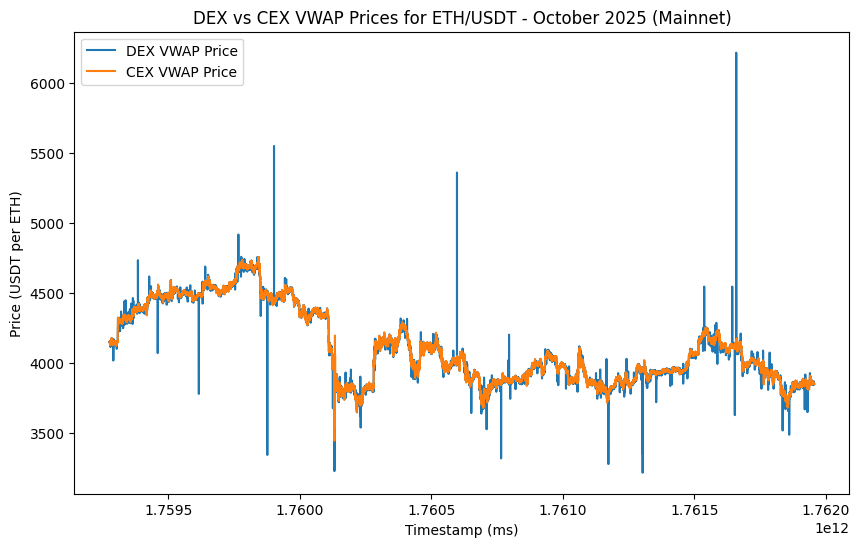

In [9]:
plt.figure(figsize = (10, 6))
plt.plot(merged.index, merged['dex_price'], label = 'DEX VWAP Price')
plt.plot(merged.index, merged['cex_price'], label = 'CEX VWAP Price')
plt.xlabel('Timestamp (ms)')
plt.ylabel('Price (USDT per ETH)')
plt.title('DEX vs CEX VWAP Prices for ETH/USDT - October 2025 (Mainnet)')
plt.legend()
plt.show()

In [2]:
df_eth = pq.read_table("eth_usdt_uniswap_v3_mainnet_oct2025").to_pandas()

In [3]:
df_eth.to_parquet('eth_usdt_dex_oct2025_mainnet.parquet', engine = 'fastparquet')

In [4]:
df_eth

,id,timestamp,eth_amount,usdt_amount,price_usdt_per_eth,pool,symbolA,symbolB,qtyA,qtyB,date
0,0x1ead61ecbb172717028a86393370e49186f3de023149...,1759276811,-1.000194,4147.022412,4146.216013,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,USDT,-1.000194,4147.022412,20251001
1,0xbb5339627b16b5f3423a9284d1d4429210b40b5a9148...,1759276811,-2.242273,9296.132289,4145.851527,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-2.242273,9296.132289,20251001
2,0xda1732cb4fddba3f5cdf860b51901f94f4209acf7ff7...,1759276811,-11.896334,49324.643911,4146.205526,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,-11.896334,49324.643911,20251001
3,0xf92a1f6072d3ff7be2c9fcae84fdc24fe5f3b5e4e868...,1759276811,0.034648,-142.805219,4121.601882,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,0.034648,-142.805219,20251001
4,0xcdae92d918467ebad62243c8ee7a0498cf88e3c709d6...,1759276823,0.167588,-694.762010,4145.654251,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,0.167588,-694.762010,20251001
...,...,...,...,...,...,...,...,...,...,...,...
695944,0xa87ddabd6b6190dbac59fe11259d8acffcaea7284dd5...,1761965963,-0.000051,0.195074,3852.942001,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.000051,0.195074,20251101
695945,0xdbd3028a5a822b40e55e45f23dcc113ba6f1c1921741...,1761965963,-0.119838,461.829068,3853.776998,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.119838,461.829068,20251101
695946,0xe71cafaeb0178a2e6c748ed13f9cb81197db4f3dbcbc...,1761965975,-0.117335,452.088768,3852.964085,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.117335,452.088768,20251101
695947,0x4a5233a66c474008435af34dc56a5a6a4f09ab89e4eb...,1761965987,-0.360379,1388.574315,3853.093541,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.360379,1388.574315,20251101


# CEX data burst agggregation

In [2]:
dataset = ds.dataset("ETHUSDT-aggTrades-2025-10.parquet", format="parquet")
eth_usdt = dataset.to_table().to_pandas()
eth_usdt.columns = ['agg_trade_id', 'price', 'quantity', 'first_trade_id', 'last_trade_id', 'timestamp', 'is_buyer_maker', 'is_best_match']
eth_usdt['timestamp'] = pd.to_datetime(eth_usdt['timestamp'], unit = 'us')

In [3]:
eth_usdt

,agg_trade_id,price,quantity,first_trade_id,last_trade_id,timestamp,is_buyer_maker,is_best_match
0,1720750794,4145.15,2.0509,2902981422,2902981434,2025-10-01 00:00:00.962468,False,True
1,1720750795,4145.16,0.2192,2902981435,2902981440,2025-10-01 00:00:00.962468,False,True
2,1720750796,4145.17,0.0133,2902981441,2902981443,2025-10-01 00:00:00.962468,False,True
3,1720750797,4145.18,0.0033,2902981444,2902981445,2025-10-01 00:00:00.962468,False,True
4,1720750798,4145.19,0.0013,2902981446,2902981446,2025-10-01 00:00:00.962468,False,True
...,...,...,...,...,...,...,...,...
50227407,1770978201,3847.99,0.0182,3085461440,3085461440,2025-10-31 23:59:57.626545,True,True
50227408,1770978202,3847.99,0.0025,3085461441,3085461441,2025-10-31 23:59:58.841962,True,True
50227409,1770978203,3847.99,14.1407,3085461442,3085461445,2025-10-31 23:59:58.913534,True,True
50227410,1770978204,3847.99,0.0044,3085461446,3085461446,2025-10-31 23:59:59.595158,True,True


In [4]:
import polars as pl

def aggregate_exact_timestamp(df: pl.DataFrame) -> pl.DataFrame:
    """
    Collapse CEX trades that share the exact same microsecond timestamp
    and side (is_buyer_maker).
    
    Computes VWAP using vectorized Polars.
    """
    df = pl.from_pandas(df)
    # Convert datetime → microseconds integer (fast group key)
    df = df.with_columns(
        ts_us = pl.col("timestamp").cast(pl.Datetime("us")).cast(pl.Int64)
    )

    return (
        df.with_columns(
            trade_value = pl.col("price") * pl.col("quantity")
        )
        .group_by(["ts_us", "is_buyer_maker"])
        .agg([
            pl.sum("quantity").alias("total_quantity"),
            pl.sum("trade_value").alias("total_value"),
            pl.count().alias("num_trades")
        ])
        .with_columns(
            vwap_price = pl.col("total_value") / pl.col("total_quantity"),
            timestamp = pl.col("ts_us").cast(pl.Datetime("us"))
        )
        .select([
            "timestamp",
            "is_buyer_maker",
            "total_quantity",
            "vwap_price",
            "num_trades"
        ])
    )


In [5]:
out = aggregate_exact_timestamp(eth_usdt)

C:\Users\steph\AppData\Local\Temp\ipykernel_37004\603517154.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("num_trades")


In [6]:
out

timestamp,is_buyer_maker,total_quantity,vwap_price,num_trades
datetime[μs],bool,f64,f64,u32
2025-10-16 19:03:46.919986,true,0.5605,3888.75,1
2025-10-17 03:21:02.213515,true,0.0509,3927.8289,2
2025-10-14 04:53:16.126200,true,0.4893,4087.386963,12
2025-10-21 21:24:00.319735,true,0.8176,3927.370205,2
2025-10-16 16:46:44.164460,true,0.0061,3892.31082,3
…,…,…,…,…
2025-10-08 06:13:27.506879,false,0.7283,4446.62,1
2025-10-10 21:46:41.237649,true,0.006,3869.32,1
2025-10-10 22:25:29.699548,true,0.0949,3851.19,1


In [9]:
out.write_parquet('eth_usdt_cex_aggregated_oct2025.parquet')

In [3]:
import polars as pl
import pandas as pd

def aggregate_bursts_polars(df, microsecond_threshold: int = 2) -> pl.DataFrame:
    """
    Collapse trade bursts where:
      - is_buyer_maker stays the same
      - timestamps differ by <= microsecond_threshold
    """

    # Auto-convert pandas → Polars
    if isinstance(df, pd.DataFrame):
        df = pl.from_pandas(df)

    # Convert timestamp -> integer µs for fast comparisons
    df = (
        df.with_columns(
            ts_us = pl.col("timestamp").cast(pl.Datetime("us")).cast(pl.Int64)
        )
        .sort("ts_us")
    )

    # Compute deltas and side flips
    df = df.with_columns([
        (pl.col("ts_us") - pl.col("ts_us").shift(1)).alias("d_us"),
        (pl.col("is_buyer_maker") != pl.col("is_buyer_maker").shift(1)).alias("side_change"),
    ])

    # Determine new burst boundaries
    df = df.with_columns(
        new_burst = (
            (pl.col("d_us") > microsecond_threshold) |
            (pl.col("side_change"))
        ).fill_null(True).cast(pl.Int64)
    )

    # Global cumulative sum: use a constant key (compatible across versions)
    df = df.with_columns(
        burst_id = pl.col("new_burst").cum_sum().over(pl.lit(1))
    )

    # Compute trade value for VWAP
    df = df.with_columns(
        trade_value = pl.col("price") * pl.col("quantity")
    )

    # Final aggregation
    out = (
        df.group_by(["burst_id", "is_buyer_maker"])
        .agg([
            pl.min("ts_us").alias("start_ts_us"),
            pl.max("ts_us").alias("end_ts_us"),
            pl.sum("quantity").alias("total_quantity"),
            pl.sum("trade_value").alias("total_value"),
            pl.count().alias("num_trades"),
        ])
        .with_columns(
            vwap_price = pl.col("total_value") / pl.col("total_quantity"),
            start_timestamp = pl.col("start_ts_us").cast(pl.Datetime("us")),
            end_timestamp   = pl.col("end_ts_us").cast(pl.Datetime("us")),
        )
        .select([
            "start_timestamp",
            "end_timestamp",
            "is_buyer_maker",
            "total_quantity",
            "vwap_price",
            "num_trades",
        ])
        .sort("start_timestamp").to_pandas()
    )

    return out


In [6]:
out = aggregate_bursts_polars(eth_usdt, microsecond_threshold=10)

C:\Users\steph\AppData\Local\Temp\ipykernel_15956\3573280120.py:55: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("num_trades"),


In [7]:
out

,start_timestamp,end_timestamp,is_buyer_maker,total_quantity,vwap_price,num_trades
0,2025-10-01 00:00:00.962468,2025-10-01 00:00:00.962468,False,2.2880,4145.151140,5
1,2025-10-01 00:00:00.963128,2025-10-01 00:00:00.963128,False,0.0039,4145.203333,2
2,2025-10-01 00:00:00.963873,2025-10-01 00:00:00.963873,False,0.6616,4145.315933,6
3,2025-10-01 00:00:00.966218,2025-10-01 00:00:00.966218,False,0.3217,4145.425493,5
4,2025-10-01 00:00:00.972325,2025-10-01 00:00:00.972331,False,0.2301,4145.480000,2
...,...,...,...,...,...,...
23413114,2025-10-31 23:59:57.626545,2025-10-31 23:59:57.626545,True,0.0182,3847.990000,1
23413115,2025-10-31 23:59:58.841962,2025-10-31 23:59:58.841962,True,0.0025,3847.990000,1
23413116,2025-10-31 23:59:58.913534,2025-10-31 23:59:58.913534,True,14.1407,3847.990000,1
23413117,2025-10-31 23:59:59.595158,2025-10-31 23:59:59.595158,True,0.0044,3847.990000,1


In [10]:
df_eth = pq.read_table("eth_usdt_uniswap_v3_mainnet_oct2025").to_pandas()

In [14]:
df_eth

,id,timestamp,eth_amount,usdt_amount,price_usdt_per_eth,pool,symbolA,symbolB,qtyA,qtyB,date
0,0x1ead61ecbb172717028a86393370e49186f3de023149...,1759276811,-1.000194,4147.022412,4146.216013,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,USDT,-1.000194,4147.022412,20251001
1,0xbb5339627b16b5f3423a9284d1d4429210b40b5a9148...,1759276811,-2.242273,9296.132289,4145.851527,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-2.242273,9296.132289,20251001
2,0xda1732cb4fddba3f5cdf860b51901f94f4209acf7ff7...,1759276811,-11.896334,49324.643911,4146.205526,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,-11.896334,49324.643911,20251001
3,0xf92a1f6072d3ff7be2c9fcae84fdc24fe5f3b5e4e868...,1759276811,0.034648,-142.805219,4121.601882,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,0.034648,-142.805219,20251001
4,0xcdae92d918467ebad62243c8ee7a0498cf88e3c709d6...,1759276823,0.167588,-694.762010,4145.654251,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,0.167588,-694.762010,20251001
...,...,...,...,...,...,...,...,...,...,...,...
695944,0xa87ddabd6b6190dbac59fe11259d8acffcaea7284dd5...,1761965963,-0.000051,0.195074,3852.942001,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.000051,0.195074,20251101
695945,0xdbd3028a5a822b40e55e45f23dcc113ba6f1c1921741...,1761965963,-0.119838,461.829068,3853.776998,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.119838,461.829068,20251101
695946,0xe71cafaeb0178a2e6c748ed13f9cb81197db4f3dbcbc...,1761965975,-0.117335,452.088768,3852.964085,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.117335,452.088768,20251101
695947,0x4a5233a66c474008435af34dc56a5a6a4f09ab89e4eb...,1761965987,-0.360379,1388.574315,3853.093541,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-0.360379,1388.574315,20251101


In [15]:
df_eth.columns

Index(['id', 'timestamp', 'eth_amount', 'usdt_amount', 'price_usdt_per_eth',
       'pool', 'symbolA', 'symbolB', 'qtyA', 'qtyB', 'date'],
      dtype='object')

In [14]:
import polars as pl
import pandas as pd

def merge_union_ffill(bursts: pl.DataFrame, other_df, tolerance_us=None):
    # --- Convert DEX pandas → Polars if needed ---
    if isinstance(other_df, pd.DataFrame):
        other = pl.from_pandas(other_df)
    else:
        other = other_df

    # --- Ensure DEX timestamps become Int64 microseconds ---
    other = other.with_columns(
        ts_us = (pl.col("timestamp").cast(pl.Int64) * 1_000_000).cast(pl.Int64)
    )

    # --- Convert bursts ("out") timestamps into same Int64 format ---
    bursts = bursts.rename({"timestamp": "ts_us"})
    bursts = bursts.with_columns(pl.col("ts_us").cast(pl.Int64))

    # --- UNION TIMELINE (all timestamps from both sides) ---
    ts_union = (
        pl.concat([
            bursts.select("ts_us"),
            other.select("ts_us")
        ])
        .unique()
        .sort("ts_us")
    )

    # --- Join CEX bursts onto union timeline (left join) ---
    frame = ts_union.join(bursts, on="ts_us", how="left")

    # --- ASOF-join DEX onto union timeline (nearest DEX row) ---
    frame = frame.join_asof(
        other.sort("ts_us"),
        on="ts_us",
        strategy="nearest",
        tolerance=tolerance_us
    )

    # --- Forward-fill ALL columns except ts_us ---
    cols_to_ffill = [c for c in frame.columns if c != "ts_us"]
    frame = frame.with_columns(
        [pl.col(c).fill_null(strategy="forward") for c in cols_to_ffill]
    )

    # --- Convert ts_us → actual datetime for readability ---
    frame = frame.with_columns(timestamp = pl.col("ts_us").cast(pl.Datetime("us")))

    return frame.sort("timestamp")


In [11]:
# Clean DEX dataframe so Polars doesn't create Object dtype columns
df_eth_clean = df_eth.copy()

# Cast all object columns to string
obj_cols = df_eth_clean.select_dtypes(include=["object"]).columns
df_eth_clean[obj_cols] = df_eth_clean[obj_cols].astype(str)
df_eth_pl = pl.from_pandas(df_eth_clean)
print(df_eth_pl.schema)

Schema({'id': String, 'timestamp': Int64, 'eth_amount': Float64, 'usdt_amount': Float64, 'price_usdt_per_eth': Float64, 'pool': String, 'symbolA': String, 'symbolB': String, 'qtyA': Float64, 'qtyB': Float64, 'date': Int32})


In [15]:
merged = merge_union_ffill(out, df_eth, tolerance_us=2_000_000)

In [16]:
merged

ts_us,is_buyer_maker,total_quantity,vwap_price,num_trades,id,timestamp,eth_amount,usdt_amount,price_usdt_per_eth,pool,symbolA,symbolB,qtyA,qtyB,date
i64,bool,f64,f64,u32,str,datetime[μs],f64,f64,f64,str,str,str,f64,f64,i32
1759276800962468,false,2.288,4145.15114,5,null,2025-10-01 00:00:00.962468,null,null,null,null,null,null,null,null,null
1759276800963128,false,0.0039,4145.203333,2,null,2025-10-01 00:00:00.963128,null,null,null,null,null,null,null,null,null
1759276800963873,false,0.6616,4145.315933,6,null,2025-10-01 00:00:00.963873,null,null,null,null,null,null,null,null,null
1759276800966218,false,0.3217,4145.425493,5,null,2025-10-01 00:00:00.966218,null,null,null,null,null,null,null,null,null
1759276800972325,false,0.0483,4145.48,1,null,2025-10-01 00:00:00.972325,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1761965951000000,true,0.0026,3847.99,1,"""0xc44f958fb816368f9b9e6b417dc6…",2025-11-01 02:59:11,0.005691,-21.925981,3852.956902,"""0xc7bbec68d12a0d1830360f8ec58f…","""WETH""","""USDT""",0.005691,-21.925981,20251101
1761965963000000,true,0.0026,3847.99,1,"""0xdbd3028a5a822b40e55e45f23dcc…",2025-11-01 02:59:23,-0.119838,461.829068,3853.776998,"""0xc7bbec68d12a0d1830360f8ec58f…","""WETH""","""USDT""",-0.119838,461.829068,20251101
1761965975000000,true,0.0026,3847.99,1,"""0xe71cafaeb0178a2e6c748ed13f9c…",2025-11-01 02:59:35,-0.117335,452.088768,3852.964085,"""0xc7bbec68d12a0d1830360f8ec58f…","""WETH""","""USDT""",-0.117335,452.088768,20251101


In [17]:
merged.drop_nulls()

ts_us,is_buyer_maker,total_quantity,vwap_price,num_trades,id,timestamp,eth_amount,usdt_amount,price_usdt_per_eth,pool,symbolA,symbolB,qtyA,qtyB,date
i64,bool,f64,f64,u32,str,datetime[μs],f64,f64,f64,str,str,str,f64,f64,i32
1759276809408510,false,0.0051,4146.37,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:09.408510,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276809653482,false,0.0504,4146.37,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:09.653482,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276809751547,false,0.0086,4146.37,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:09.751547,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276810054204,true,0.055,4146.36,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:10.054204,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276810556363,true,0.0139,4146.36,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:10.556363,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1761965951000000,true,0.0026,3847.99,1,"""0xc44f958fb816368f9b9e6b417dc6…",2025-11-01 02:59:11,0.005691,-21.925981,3852.956902,"""0xc7bbec68d12a0d1830360f8ec58f…","""WETH""","""USDT""",0.005691,-21.925981,20251101
1761965963000000,true,0.0026,3847.99,1,"""0xdbd3028a5a822b40e55e45f23dcc…",2025-11-01 02:59:23,-0.119838,461.829068,3853.776998,"""0xc7bbec68d12a0d1830360f8ec58f…","""WETH""","""USDT""",-0.119838,461.829068,20251101
1761965975000000,true,0.0026,3847.99,1,"""0xe71cafaeb0178a2e6c748ed13f9c…",2025-11-01 02:59:35,-0.117335,452.088768,3852.964085,"""0xc7bbec68d12a0d1830360f8ec58f…","""WETH""","""USDT""",-0.117335,452.088768,20251101


In [18]:
final = merged.drop_nulls().select(['ts_us', 'vwap_price', 'price_usdt_per_eth', 'total_quantity', 'eth_amount'])

In [23]:
final_pd = final.to_pandas()

In [21]:
(final['vwap_price']-final['price_usdt_per_eth']).describe()

statistic,value
str,f64
"""count""",2.421902e7
"""null_count""",0.0
"""mean""",7.248501
"""std""",75.974226
"""min""",-3980.463187
"""25%""",-1.308927
"""50%""",0.119813
"""75%""",1.666817
"""max""",4692.1


In [25]:
def remove_wicks_cex_relative(df, dex_col="price_usdt_per_eth", cex_col="vwap_price", threshold=0.05):
    ratio = df[dex_col] / df[cex_col]
    mask = (ratio > 1 - threshold) & (ratio < 1 + threshold)
    return df[mask]

final_df_clean = remove_wicks_cex_relative(final_pd, threshold = 0.05)

In [26]:
final_df_clean

,ts_us,vwap_price,price_usdt_per_eth,total_quantity,eth_amount
0,1759276809408510,4146.37,4121.601882,0.0051,0.034648
1,1759276809653482,4146.37,4121.601882,0.0504,0.034648
2,1759276809751547,4146.37,4121.601882,0.0086,0.034648
3,1759276810054204,4146.36,4121.601882,0.0550,0.034648
4,1759276810556363,4146.36,4121.601882,0.0139,0.034648
...,...,...,...,...,...
24219015,1761965951000000,3847.99,3852.956902,0.0026,0.005691
24219016,1761965963000000,3847.99,3853.776998,0.0026,-0.119838
24219017,1761965975000000,3847.99,3852.964085,0.0026,-0.117335
24219018,1761965987000000,3847.99,3853.093541,0.0026,-0.360379


c:\Users\steph\anaconda3\envs\crypto\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


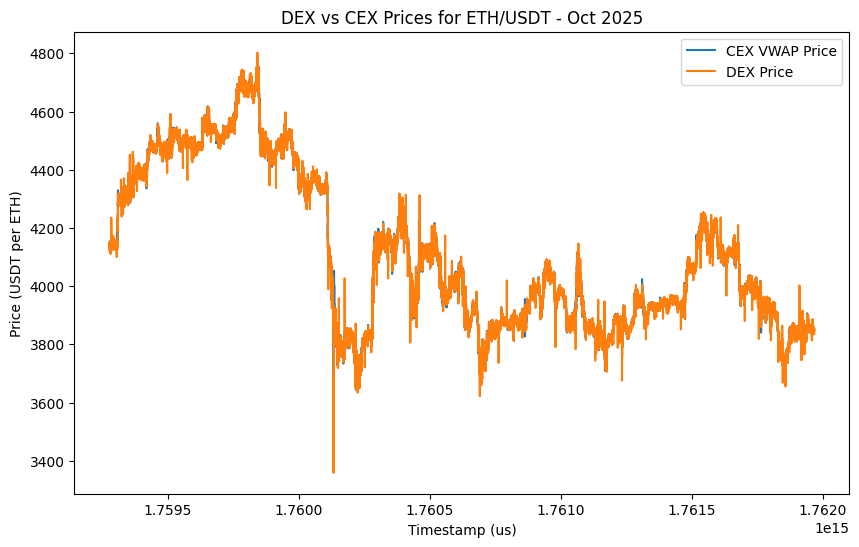

In [28]:
plt.figure(figsize = (10, 6))
plt.plot(final_df_clean['ts_us'], final_df_clean['vwap_price'], label = 'CEX VWAP Price')
plt.plot(final_df_clean['ts_us'], final_df_clean['price_usdt_per_eth'], label = 'DEX Price')
plt.xlabel('Timestamp (us)')
plt.ylabel('Price (USDT per ETH)')
plt.title('DEX vs CEX Prices for ETH/USDT - Oct 2025')
plt.legend()
plt.show()

In [ ]:
merged.head(100)

ts_us,is_buyer_maker,total_quantity,vwap_price,num_trades,id,timestamp,eth_amount,usdt_amount,price_usdt_per_eth,pool,symbolA,symbolB,qtyA,qtyB,date
i64,bool,f64,f64,u32,str,datetime[μs],f64,f64,f64,str,str,str,f64,f64,i32
1759276800962468,false,2.288,4145.15114,5,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:00.962468,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276800963128,false,0.0039,4145.203333,2,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:00.963128,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276800963873,false,0.6616,4145.315933,6,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:00.963873,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276800966218,false,0.3217,4145.425493,5,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:00.966218,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276800972325,false,0.0483,4145.48,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:00.972325,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1759276804595471,false,0.4111,4145.41,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:04.595471,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276804598911,false,1.2519,4145.41,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:04.598911,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001
1759276804607715,true,0.2036,4145.4,1,"""0xf92a1f6072d3ff7be2c9fcae84fd…",2025-10-01 00:00:04.607715,0.034648,-142.805219,4121.601882,"""0x4e68ccd3e89f51c3074ca5072bba…","""WETH""","""USDT""",0.034648,-142.805219,20251001


: 

In [29]:
final_df_clean.to_parquet('merged_hf_eth_usdt_cex_dex_oct2025.parquet', engine = 'fastparquet')


In [30]:
final_df_clean

,ts_us,vwap_price,price_usdt_per_eth,total_quantity,eth_amount
0,1759276809408510,4146.37,4121.601882,0.0051,0.034648
1,1759276809653482,4146.37,4121.601882,0.0504,0.034648
2,1759276809751547,4146.37,4121.601882,0.0086,0.034648
3,1759276810054204,4146.36,4121.601882,0.0550,0.034648
4,1759276810556363,4146.36,4121.601882,0.0139,0.034648
...,...,...,...,...,...
24219015,1761965951000000,3847.99,3852.956902,0.0026,0.005691
24219016,1761965963000000,3847.99,3853.776998,0.0026,-0.119838
24219017,1761965975000000,3847.99,3852.964085,0.0026,-0.117335
24219018,1761965987000000,3847.99,3853.093541,0.0026,-0.360379
